# Time Series Analysis and Forecasting for Power Systems

## Introduction

Time series analysis is fundamental to power system operations. System operators rely on accurate forecasts for load scheduling, unit commitment, and reserve planning. This lesson applies time series techniques specifically to power system data, focusing on practical forecasting methods used in the industry.

Power systems exhibit strong temporal patterns driven by human behavior, weather conditions, and industrial activities. Understanding these patterns and building reliable forecasts is crucial for maintaining grid stability and economic efficiency.

## Learning Objectives

By the end of this lesson, you will be able to:

1. Identify and analyze temporal patterns in power system data
2. Decompose time series to understand trend, seasonal, and residual components
3. Apply autocorrelation analysis for model selection
4. Implement practical forecasting methods for load and generation
5. Evaluate forecast accuracy using industry-standard metrics
6. Handle real-world challenges in power system forecasting

## Prerequisites

This lesson builds on:
- Python fundamentals (Lesson 1)
- NumPy for numerical computation (Lesson 2)
- Pandas for data manipulation (Lesson 3)
- Data visualization techniques (Lesson 4)

In [1]:
# Import required libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller

!pip install scikit-learn

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error
import warnings
warnings.filterwarnings('ignore')

# Set random seed for reproducibility
np.random.seed(42)

# Configure display options
pd.set_option('display.precision', 2)
plt.style.use('seaborn-v0_8-whitegrid')

print("Libraries loaded successfully")
print(f"Pandas version: {pd.__version__}")

Libraries loaded successfully
Pandas version: 2.3.1


## 1. Time Series Patterns in Power Systems

Power system data exhibits distinct patterns that reflect the underlying physics and human behavior. Let's create and analyze realistic power system time series data.

In [2]:
# Generate two years of hourly load data with realistic patterns
dates = pd.date_range(start='2022-01-01', end='2023-12-31 23:00:00', freq='H')
n_hours = len(dates)

# Base load
base_load = 5000  # MW

# Long-term trend (slight growth)
trend = np.linspace(0, 200, n_hours)  # 200 MW growth over 2 years

# Annual seasonality (higher in summer and winter)
annual_pattern = 300 * np.sin(2 * np.pi * (dates.dayofyear - 80) / 365.25)  # Peak in summer
annual_pattern += 200 * np.sin(4 * np.pi * dates.dayofyear / 365.25)  # Secondary peak in winter

# Weekly seasonality (lower on weekends)
weekly_pattern = np.where(dates.weekday < 5, 0, -500)  # 500 MW reduction on weekends

# Daily seasonality (double peak pattern)
daily_pattern = (
    -200 * np.cos(2 * np.pi * (dates.hour - 6) / 24) +  # Morning peak around 9 AM
    -150 * np.cos(2 * np.pi * (dates.hour - 18) / 24)   # Evening peak around 6 PM
)

# Temperature effect (simplified)
temperature = 20 + 10 * np.sin(2 * np.pi * (dates.dayofyear - 80) / 365.25) + \
              5 * np.sin(2 * np.pi * dates.hour / 24) + \
              np.random.normal(0, 2, n_hours)

# Temperature-dependent load (cooling and heating)
temp_load = 20 * (temperature - 20)**2  # Quadratic relationship

# Random noise
noise = np.random.normal(0, 100, n_hours)

# Combine all components
load = base_load + trend + annual_pattern + weekly_pattern + daily_pattern + temp_load + noise
load = np.maximum(load, 3000)  # Minimum load constraint

# Create DataFrame
load_data = pd.DataFrame({
    'datetime': dates,
    'load': load,
    'temperature': temperature,
    'weekday': dates.weekday,
    'hour': dates.hour,
    'month': dates.month,
    'dayofyear': dates.dayofyear
})
load_data.set_index('datetime', inplace=True)

print("Generated 2 years of hourly load data")
print(f"Shape: {load_data.shape}")
print(f"Load range: {load_data['load'].min():.0f} - {load_data['load'].max():.0f} MW")
print("\nFirst few rows:")
print(load_data.head())

Generated 2 years of hourly load data
Shape: (17520, 6)
Load range: 3887 - 14240 MW

First few rows:
                        load  temperature  weekday  hour  month  dayofyear
datetime                                                                  
2022-01-01 00:00:00  5768.48        11.22        5     0      1          1
2022-01-01 01:00:00  5807.09        11.24        5     1      1          1
2022-01-01 02:00:00  4818.23        14.02        5     2      1          1
2022-01-01 03:00:00  4551.97        16.81        5     3      1          1
2022-01-01 04:00:00  4665.29        14.09        5     4      1          1


### Visualizing Time Series Patterns

Let's visualize the data at different time scales to identify patterns:

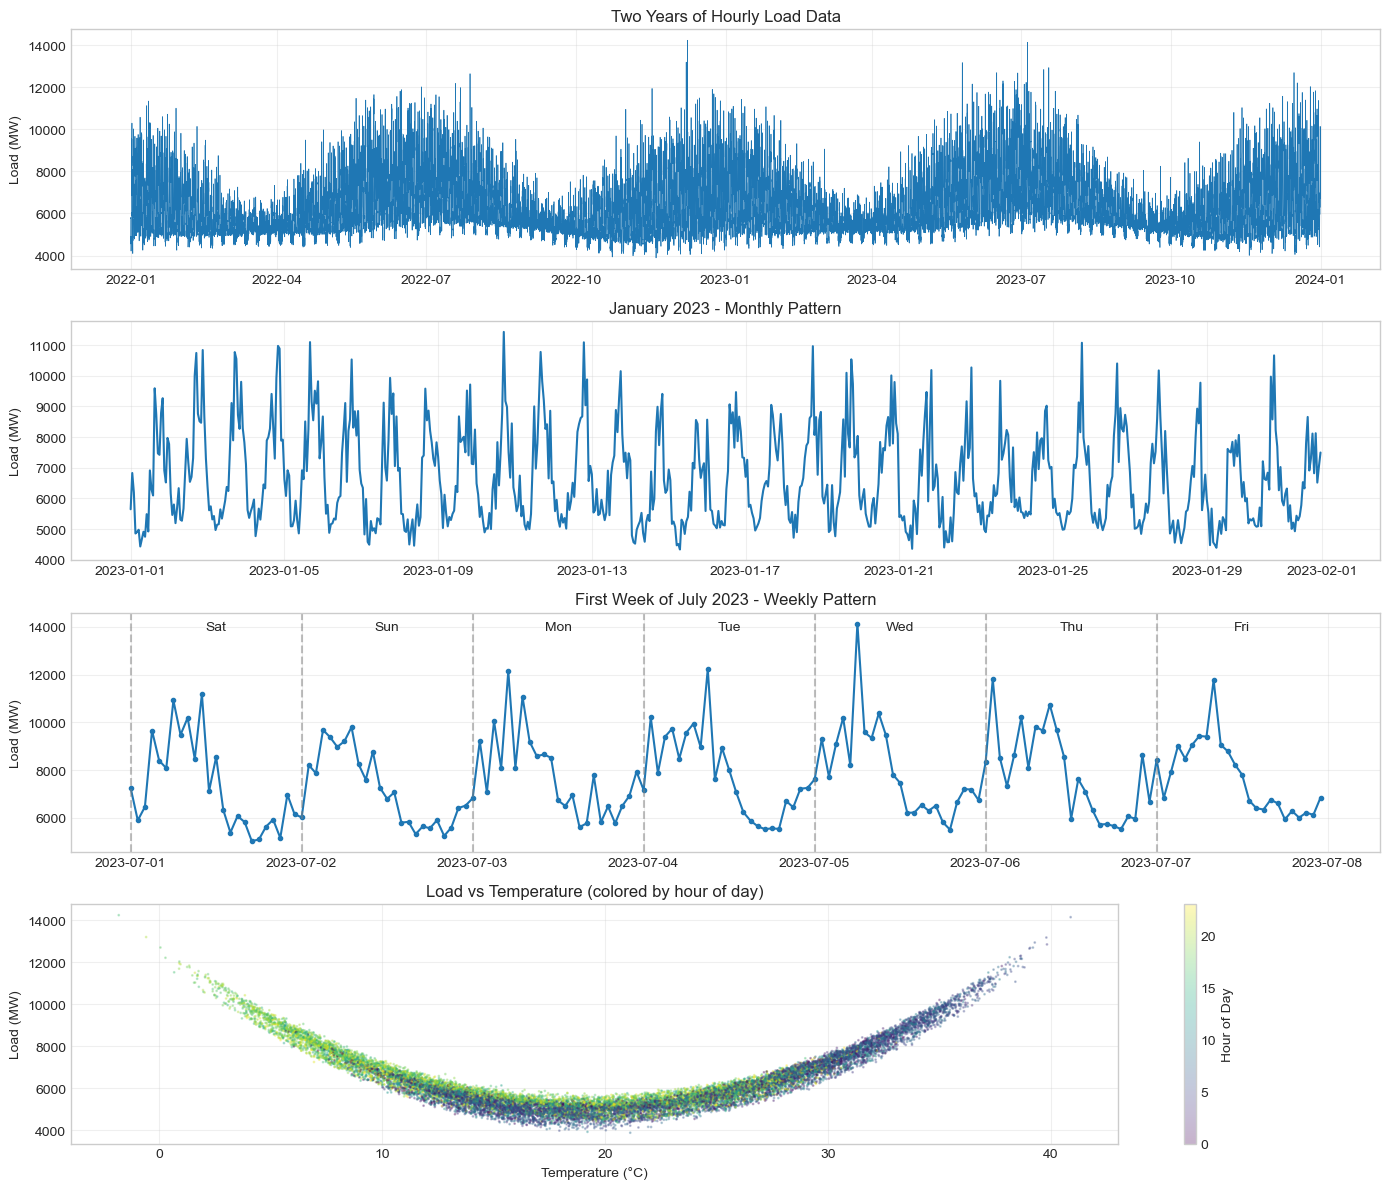


Pattern Analysis:
Average weekday load: 6422 MW
Average weekend load: 5927 MW
Weekend reduction: 7.7%

Average summer load: 6976 MW
Average winter load: 6480 MW


In [3]:
# Create multi-scale visualization
fig, axes = plt.subplots(4, 1, figsize=(14, 12))

# 1. Full two years
ax = axes[0]
ax.plot(load_data.index, load_data['load'], linewidth=0.5)
ax.set_title('Two Years of Hourly Load Data')
ax.set_ylabel('Load (MW)')
ax.grid(True, alpha=0.3)

# 2. One month (January 2023)
ax = axes[1]
jan_2023 = load_data.loc['2023-01']
ax.plot(jan_2023.index, jan_2023['load'])
ax.set_title('January 2023 - Monthly Pattern')
ax.set_ylabel('Load (MW)')
ax.grid(True, alpha=0.3)

# 3. One week (first week of July 2023)
ax = axes[2]
week_data = load_data['2023-07-01':'2023-07-07']
ax.plot(week_data.index, week_data['load'], marker='o', markersize=3)
ax.set_title('First Week of July 2023 - Weekly Pattern')
ax.set_ylabel('Load (MW)')
ax.grid(True, alpha=0.3)
# Add day labels
for i, day in enumerate(['Sat', 'Sun', 'Mon', 'Tue', 'Wed', 'Thu', 'Fri']):
    ax.axvline(week_data.index[i*24], color='gray', linestyle='--', alpha=0.5)
    ax.text(week_data.index[i*24 + 12], ax.get_ylim()[1]*0.95, day, ha='center')

# 4. Temperature vs Load scatter
ax = axes[3]
scatter = ax.scatter(load_data['temperature'], load_data['load'], 
                    c=load_data['hour'], cmap='viridis', alpha=0.3, s=1)
ax.set_xlabel('Temperature (°C)')
ax.set_ylabel('Load (MW)')
ax.set_title('Load vs Temperature (colored by hour of day)')
cbar = plt.colorbar(scatter, ax=ax)
cbar.set_label('Hour of Day')
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Print pattern statistics
print("\nPattern Analysis:")
print(f"Average weekday load: {load_data[load_data['weekday'] < 5]['load'].mean():.0f} MW")
print(f"Average weekend load: {load_data[load_data['weekday'] >= 5]['load'].mean():.0f} MW")
print(f"Weekend reduction: {(1 - load_data[load_data['weekday'] >= 5]['load'].mean() / load_data[load_data['weekday'] < 5]['load'].mean()) * 100:.1f}%")

summer_load = load_data[load_data['month'].isin([6, 7, 8])]['load'].mean()
winter_load = load_data[load_data['month'].isin([12, 1, 2])]['load'].mean()
print(f"\nAverage summer load: {summer_load:.0f} MW")
print(f"Average winter load: {winter_load:.0f} MW")

```{admonition} Exercise 1: Identify Time Series Patterns
:class: tip

Using the load data, identify and visualize:
1. The typical daily load profile for weekdays vs weekends
2. The monthly average load pattern across the year
3. The relationship between temperature and load for different seasons
4. Any special days (holidays) with unusual patterns

```

In [4]:
# Exercise 1: Your code here
# Identify and visualize time series patterns

# Your solution:

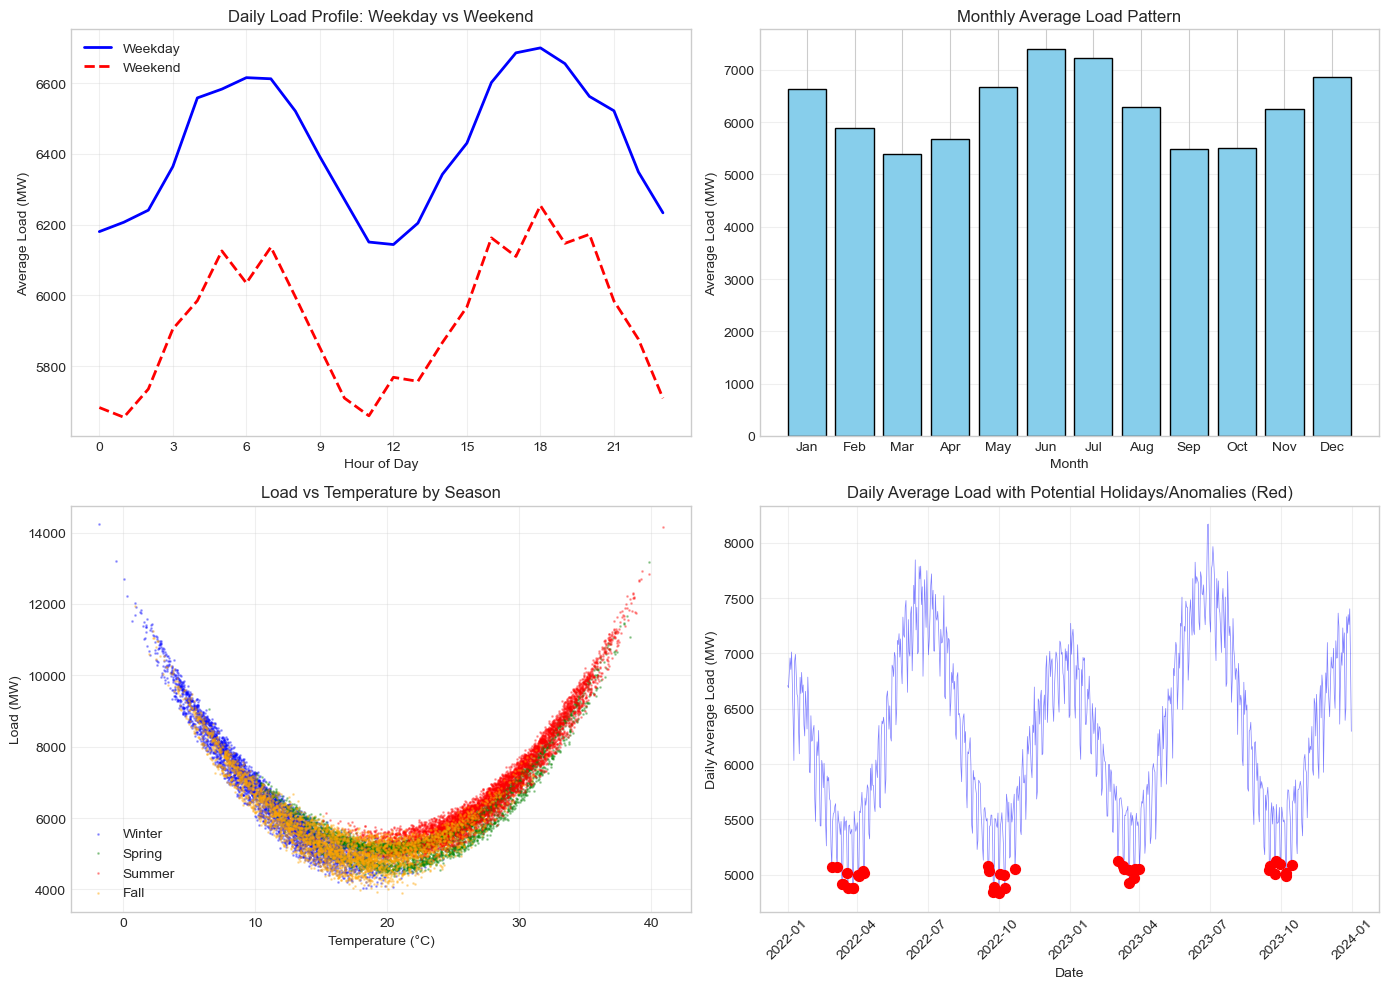

Potential holidays/special days (lowest 5% load days):
2022-02-27 (Sunday): 5070 MW
2022-03-06 (Sunday): 5073 MW
2022-03-12 (Saturday): 4920 MW
2022-03-13 (Sunday): 4914 MW
2022-03-19 (Saturday): 5013 MW
2022-03-20 (Sunday): 4883 MW
2022-03-26 (Saturday): 4876 MW
2022-03-27 (Sunday): 4878 MW
2022-04-02 (Saturday): 4993 MW
2022-04-03 (Sunday): 4991 MW
2022-04-09 (Saturday): 5032 MW
2022-04-10 (Sunday): 5011 MW
2022-09-17 (Saturday): 5081 MW
2022-09-18 (Sunday): 5035 MW
2022-09-24 (Saturday): 4843 MW
2022-09-25 (Sunday): 4891 MW
2022-10-01 (Saturday): 4830 MW
2022-10-02 (Sunday): 5004 MW
2022-10-08 (Saturday): 4997 MW
2022-10-09 (Sunday): 4883 MW
2022-10-22 (Saturday): 5051 MW
2023-03-04 (Saturday): 5125 MW
2023-03-11 (Saturday): 5079 MW
2023-03-12 (Sunday): 5051 MW
2023-03-18 (Saturday): 5046 MW
2023-03-19 (Sunday): 4926 MW
2023-03-25 (Saturday): 4967 MW
2023-03-26 (Sunday): 5050 MW
2023-04-01 (Saturday): 5050 MW
2023-09-16 (Saturday): 5042 MW
2023-09-17 (Sunday): 5076 MW
2023-09-23 (Sa

In [5]:
# Solution
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# 1. Daily profile: weekdays vs weekends
ax = axes[0, 0]
weekday_profile = load_data[load_data['weekday'] < 5].groupby('hour')['load'].mean()
weekend_profile = load_data[load_data['weekday'] >= 5].groupby('hour')['load'].mean()

ax.plot(weekday_profile.index, weekday_profile.values, 'b-', linewidth=2, label='Weekday')
ax.plot(weekend_profile.index, weekend_profile.values, 'r--', linewidth=2, label='Weekend')
ax.set_xlabel('Hour of Day')
ax.set_ylabel('Average Load (MW)')
ax.set_title('Daily Load Profile: Weekday vs Weekend')
ax.legend()
ax.grid(True, alpha=0.3)
ax.set_xticks(range(0, 24, 3))

# 2. Monthly average pattern
ax = axes[0, 1]
monthly_avg = load_data.groupby('month')['load'].mean()
ax.bar(monthly_avg.index, monthly_avg.values, color='skyblue', edgecolor='black')
ax.set_xlabel('Month')
ax.set_ylabel('Average Load (MW)')
ax.set_title('Monthly Average Load Pattern')
ax.set_xticks(range(1, 13))
ax.set_xticklabels(['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 
                    'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
ax.grid(True, alpha=0.3, axis='y')

# 3. Temperature vs Load by season
ax = axes[1, 0]
seasons = {
    'Winter': [12, 1, 2],
    'Spring': [3, 4, 5],
    'Summer': [6, 7, 8],
    'Fall': [9, 10, 11]
}
colors = ['blue', 'green', 'red', 'orange']

for (season, months), color in zip(seasons.items(), colors):
    season_data = load_data[load_data['month'].isin(months)]
    ax.scatter(season_data['temperature'], season_data['load'], 
              alpha=0.3, s=1, label=season, color=color)

ax.set_xlabel('Temperature (°C)')
ax.set_ylabel('Load (MW)')
ax.set_title('Load vs Temperature by Season')
ax.legend()
ax.grid(True, alpha=0.3)

# 4. Identify anomalies (simplified - looking for low load days)
ax = axes[1, 1]
daily_avg = load_data.resample('D')['load'].mean()
threshold = daily_avg.quantile(0.05)  # Bottom 5% as potential holidays

anomalies = daily_avg[daily_avg < threshold]
ax.plot(daily_avg.index, daily_avg.values, 'b-', alpha=0.5, linewidth=0.5)
ax.scatter(anomalies.index, anomalies.values, color='red', s=50, zorder=5)
ax.set_xlabel('Date')
ax.set_ylabel('Daily Average Load (MW)')
ax.set_title('Daily Average Load with Potential Holidays/Anomalies (Red)')
ax.grid(True, alpha=0.3)

# Rotate x-labels
for tick in ax.get_xticklabels():
    tick.set_rotation(45)

plt.tight_layout()
plt.show()

# Print anomaly dates
print("Potential holidays/special days (lowest 5% load days):")
for date, load in anomalies.items():
    print(f"{date.strftime('%Y-%m-%d (%A)')}: {load:.0f} MW")

## 2. Time Series Decomposition

Time series decomposition separates data into trend, seasonal, and residual components. This helps understand the underlying structure and is crucial for forecasting.

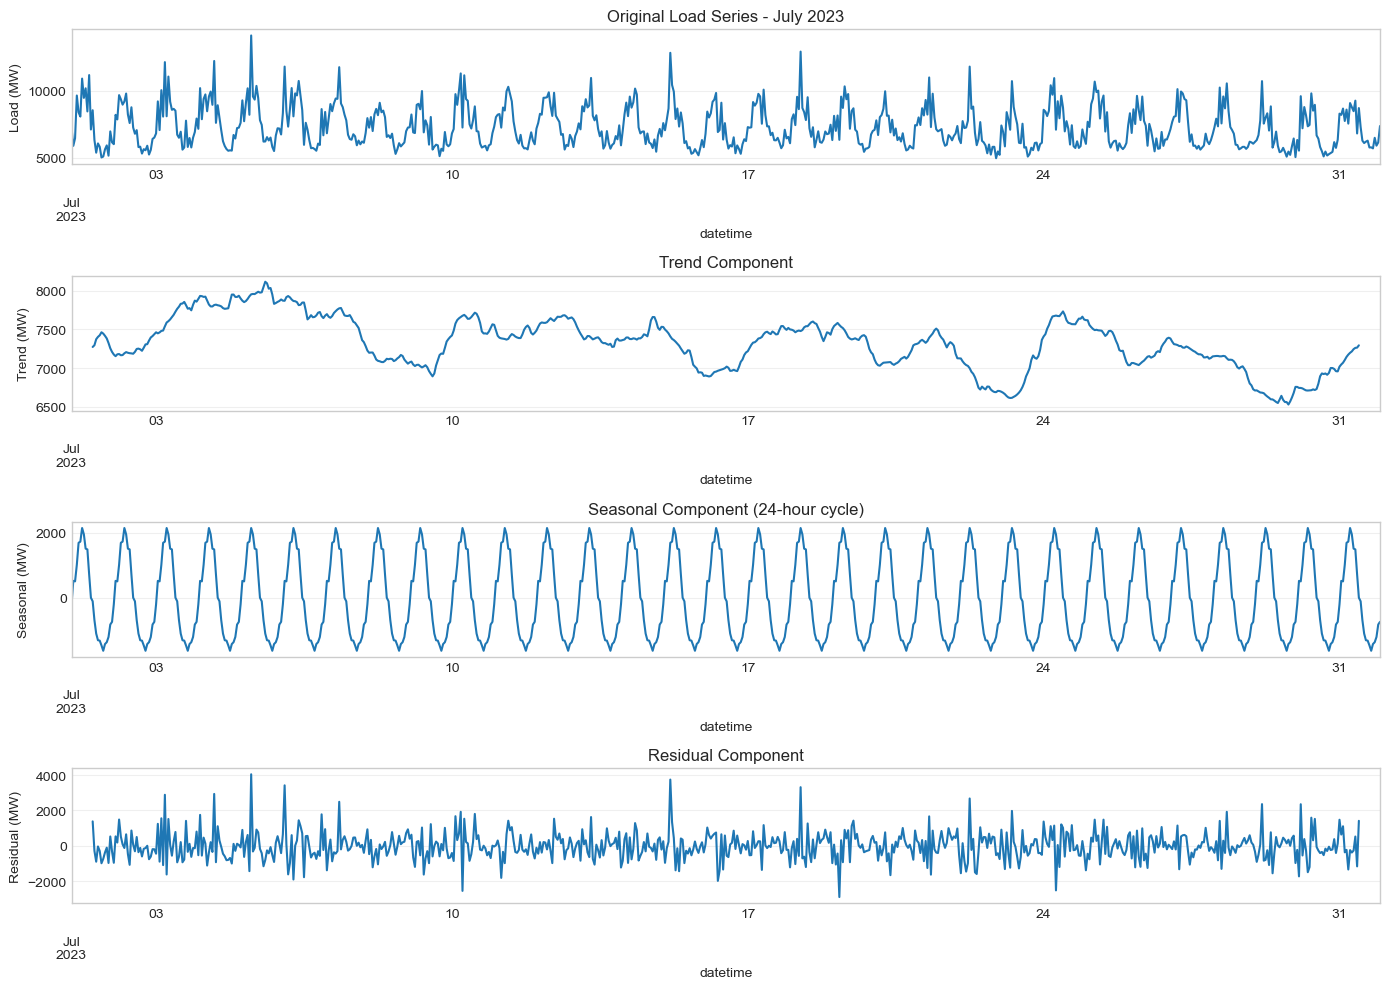

Decomposition Analysis:
Trend range: 6528 - 8116 MW
Seasonal amplitude: 3756 MW
Residual std dev: 797 MW


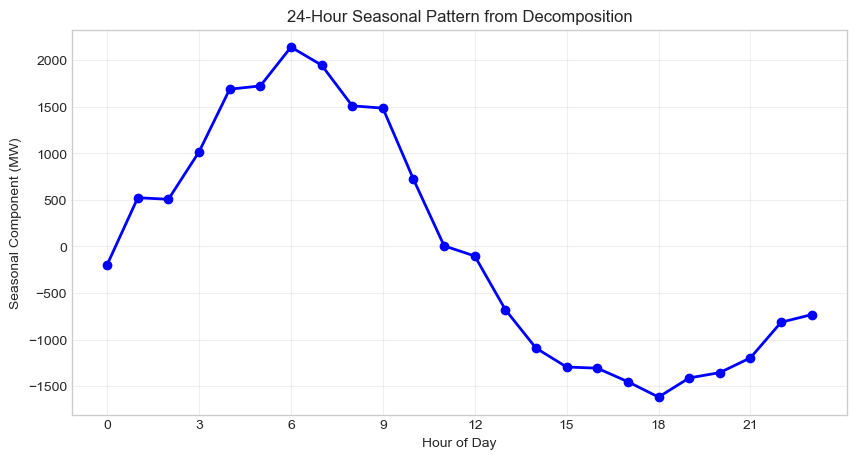

In [6]:
# Perform time series decomposition
# Using one month of data for clearer visualization
july_2023 = load_data.loc['2023-07']['load']

# Additive decomposition (appropriate when seasonal fluctuations are relatively constant)
decomposition = seasonal_decompose(july_2023, model='additive', period=24)

# Create decomposition plot
fig, axes = plt.subplots(4, 1, figsize=(14, 10))

# Original series
july_2023.plot(ax=axes[0], title='Original Load Series - July 2023')
axes[0].set_ylabel('Load (MW)')
axes[0].grid(True, alpha=0.3)

# Trend
decomposition.trend.plot(ax=axes[1], title='Trend Component')
axes[1].set_ylabel('Trend (MW)')
axes[1].grid(True, alpha=0.3)

# Seasonal
decomposition.seasonal.plot(ax=axes[2], title='Seasonal Component (24-hour cycle)')
axes[2].set_ylabel('Seasonal (MW)')
axes[2].grid(True, alpha=0.3)

# Residual
decomposition.resid.plot(ax=axes[3], title='Residual Component')
axes[3].set_ylabel('Residual (MW)')
axes[3].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Analyze components
print("Decomposition Analysis:")
print(f"Trend range: {decomposition.trend.dropna().min():.0f} - {decomposition.trend.dropna().max():.0f} MW")
print(f"Seasonal amplitude: {decomposition.seasonal.max() - decomposition.seasonal.min():.0f} MW")
print(f"Residual std dev: {decomposition.resid.dropna().std():.0f} MW")

# Show one day of seasonal pattern
one_day_seasonal = decomposition.seasonal[:24]
plt.figure(figsize=(10, 5))
plt.plot(range(24), one_day_seasonal.values, 'b-', linewidth=2, marker='o')
plt.xlabel('Hour of Day')
plt.ylabel('Seasonal Component (MW)')
plt.title('24-Hour Seasonal Pattern from Decomposition')
plt.grid(True, alpha=0.3)
plt.xticks(range(0, 24, 3))
plt.show()

```{admonition} Exercise 2: Decomposition Analysis
:class: tip

Perform time series decomposition on:
1. A winter month (January) and compare seasonal amplitude to summer
2. A full year of data to see long-term trends
3. Create a multiplicative decomposition and compare to additive

What insights can you draw about load behavior in different seasons?
```

In [7]:
# Exercise 2: Your code here
# Perform decomposition analysis on different time periods

# Your solution:

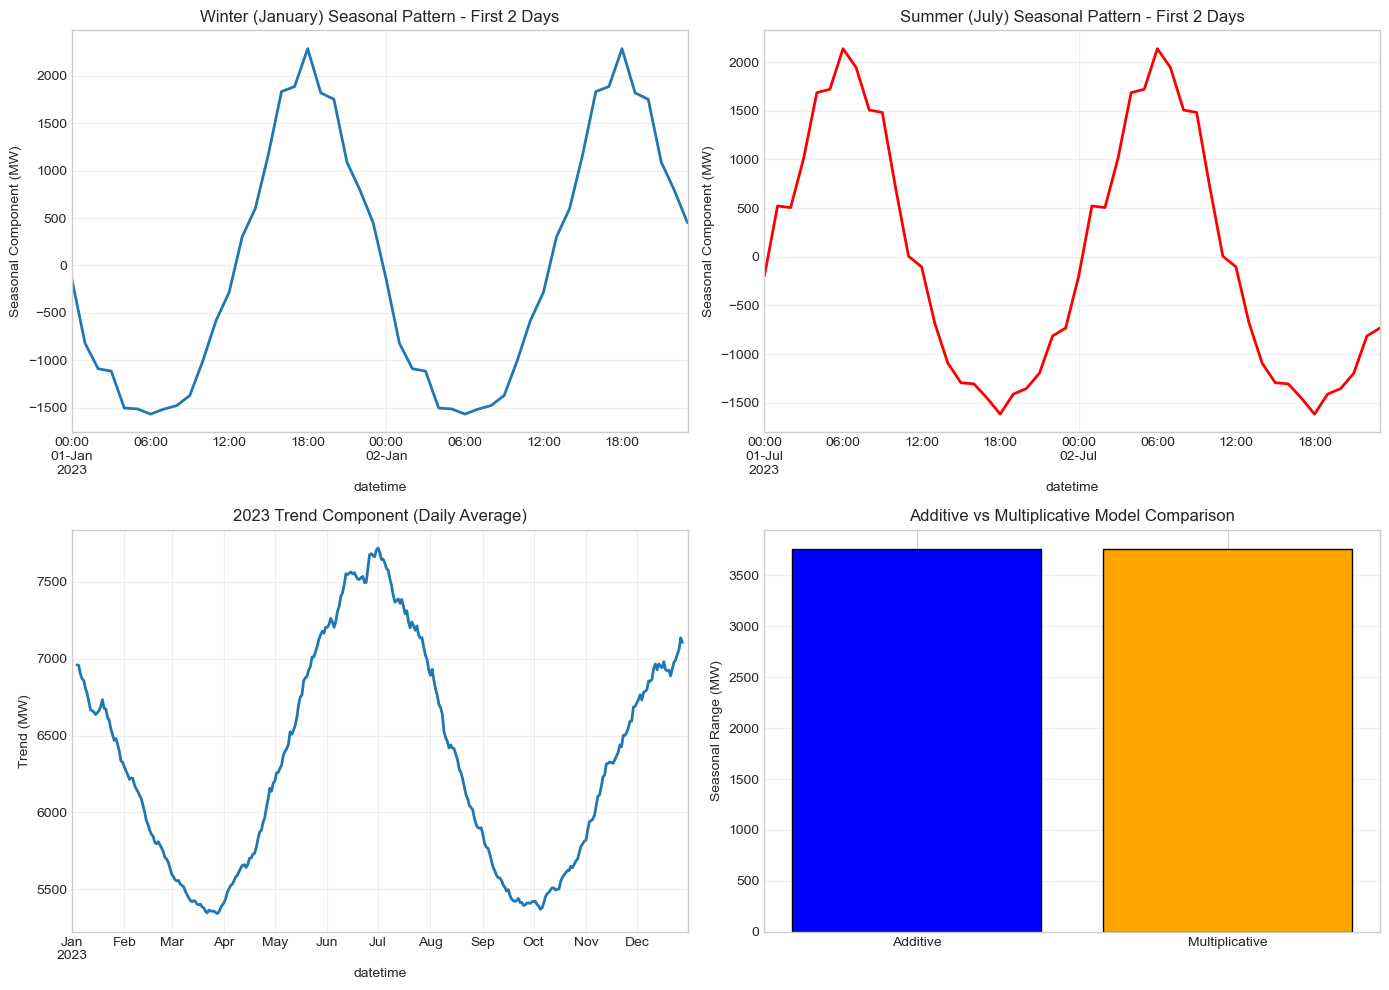

Decomposition Insights:
Winter seasonal amplitude: 3853 MW
Summer seasonal amplitude: 3756 MW
Ratio (Summer/Winter): 0.97

Yearly trend shows nan MW change over 2023
Multiplicative model suggests 65.8% variation


In [8]:
# Solution
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# 1. Winter decomposition (January 2023)
jan_2023 = load_data.loc['2023-01']['load']
winter_decomp = seasonal_decompose(jan_2023, model='additive', period=24)

ax = axes[0, 0]
winter_decomp.seasonal[:48].plot(ax=ax, linewidth=2)
ax.set_title('Winter (January) Seasonal Pattern - First 2 Days')
ax.set_ylabel('Seasonal Component (MW)')
ax.grid(True, alpha=0.3)

# 2. Summer decomposition (July 2023) for comparison
ax = axes[0, 1]
decomposition.seasonal[:48].plot(ax=ax, linewidth=2, color='red')
ax.set_title('Summer (July) Seasonal Pattern - First 2 Days')
ax.set_ylabel('Seasonal Component (MW)')
ax.grid(True, alpha=0.3)

# 3. Full year decomposition to see long-term trends
year_2023 = load_data.loc['2023']['load']
# Resample to daily for yearly decomposition
daily_load = year_2023.resample('D').mean()
year_decomp = seasonal_decompose(daily_load, model='additive', period=7)  # Weekly seasonality

ax = axes[1, 0]
year_decomp.trend.plot(ax=ax, linewidth=2)
ax.set_title('2023 Trend Component (Daily Average)')
ax.set_ylabel('Trend (MW)')
ax.grid(True, alpha=0.3)

# 4. Multiplicative vs Additive comparison
july_mult = seasonal_decompose(july_2023, model='multiplicative', period=24)

ax = axes[1, 1]
# Plot ratio of seasonal components
additive_range = decomposition.seasonal.max() - decomposition.seasonal.min()
multiplicative_range = (july_mult.seasonal.max() - july_mult.seasonal.min()) * july_2023.mean()

comparison_data = pd.DataFrame({
    'Model': ['Additive', 'Multiplicative'],
    'Seasonal Range (MW)': [additive_range, multiplicative_range]
})
ax.bar(comparison_data['Model'], comparison_data['Seasonal Range (MW)'], 
       color=['blue', 'orange'], edgecolor='black')
ax.set_ylabel('Seasonal Range (MW)')
ax.set_title('Additive vs Multiplicative Model Comparison')
ax.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

# Analysis
print("Decomposition Insights:")
print(f"Winter seasonal amplitude: {winter_decomp.seasonal.max() - winter_decomp.seasonal.min():.0f} MW")
print(f"Summer seasonal amplitude: {decomposition.seasonal.max() - decomposition.seasonal.min():.0f} MW")
print(f"Ratio (Summer/Winter): {(decomposition.seasonal.max() - decomposition.seasonal.min()) / (winter_decomp.seasonal.max() - winter_decomp.seasonal.min()):.2f}")
print(f"\nYearly trend shows {year_decomp.trend.iloc[-1] - year_decomp.trend.iloc[0]:.0f} MW change over 2023")
print(f"Multiplicative model suggests {(july_mult.seasonal.max() / july_mult.seasonal.min() - 1) * 100:.1f}% variation")

## 3. Autocorrelation and Lag Analysis

Autocorrelation measures how current values relate to past values. This is crucial for understanding temporal dependencies and selecting appropriate forecasting models.

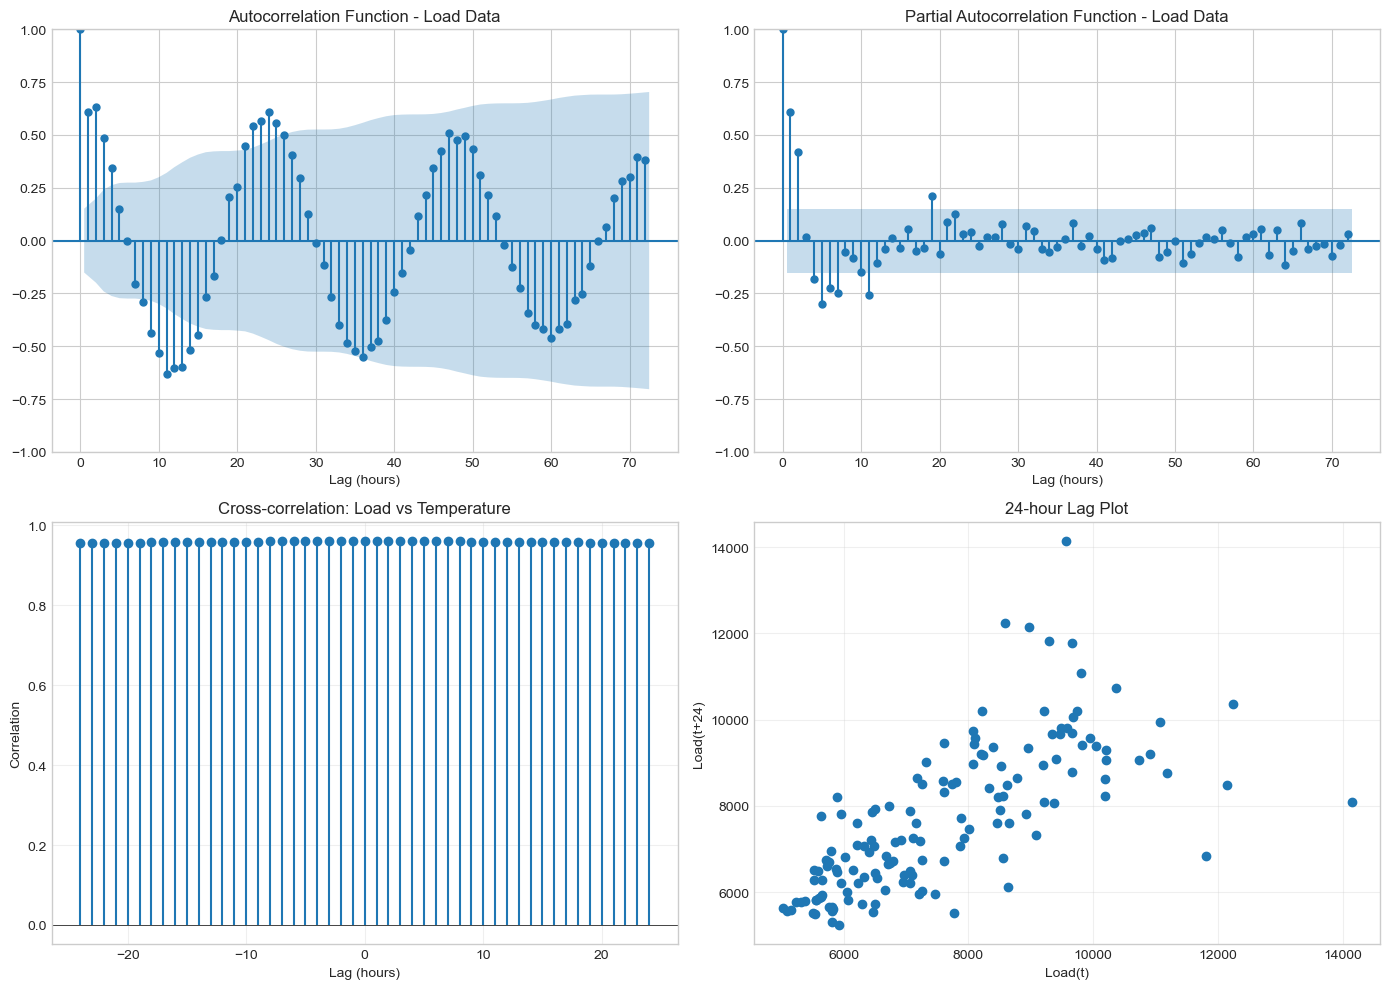

Key Autocorrelations:
24-hour lag (daily): 0.703
168-hour lag (weekly): 0.687
1-hour lag: 0.607

Augmented Dickey-Fuller Test:
Test Statistic: -7.4175
p-value: 0.0000
Series is stationary


In [9]:
# Analyze autocorrelation for load data
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Use one week of data for clarity
week_load = load_data.loc['2023-07-01':'2023-07-07']['load']

# 1. Autocorrelation Function (ACF)
ax = axes[0, 0]
plot_acf(week_load, lags=72, ax=ax)  # 3 days of lags
ax.set_title('Autocorrelation Function - Load Data')
ax.set_xlabel('Lag (hours)')

# 2. Partial Autocorrelation Function (PACF)
ax = axes[0, 1]
plot_pacf(week_load, lags=72, ax=ax)
ax.set_title('Partial Autocorrelation Function - Load Data')
ax.set_xlabel('Lag (hours)')

# 3. Cross-correlation: Load vs Temperature
ax = axes[1, 0]

# Get the week's temperature data
week_data = load_data.loc['2023-07-01':'2023-07-07']
temp_week = week_data['temperature']

# Calculate cross-correlation
cross_corr = []
lag_hours = range(-24, 25)

for lag in lag_hours:
    if lag < 0:
        # Temperature leads load (negative lag)
        # Align the series properly
        if abs(lag) < len(week_load):
            corr = week_load.iloc[-lag:].corr(temp_week.iloc[:lag])
        else:
            corr = np.nan
    elif lag > 0:
        # Load leads temperature (positive lag)
        if lag < len(week_load):
            corr = week_load.iloc[:-lag].corr(temp_week.iloc[lag:])
        else:
            corr = np.nan
    else:
        # No lag
        corr = week_load.corr(temp_week)

    cross_corr.append(corr)

# Remove NaN values for plotting
valid_lags = [l for l, c in zip(lag_hours, cross_corr) if not np.isnan(c)]
valid_corr = [c for c in cross_corr if not np.isnan(c)]

ax.stem(valid_lags, valid_corr, basefmt=' ')
ax.set_xlabel('Lag (hours)')
ax.set_ylabel('Correlation')
ax.set_title('Cross-correlation: Load vs Temperature')
ax.grid(True, alpha=0.3)
ax.axhline(y=0, color='k', linewidth=0.5)

# 4. Lag plot for visual inspection
ax = axes[1, 1]
pd.plotting.lag_plot(week_load, lag=24, ax=ax)
ax.set_title('24-hour Lag Plot')
ax.set_xlabel('Load(t)')
ax.set_ylabel('Load(t+24)')
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Calculate and display key correlations
print("Key Autocorrelations:")
print(f"24-hour lag (daily): {week_load.autocorr(lag=24):.3f}")
print(f"168-hour lag (weekly): {load_data.loc['2023-07']['load'].autocorr(lag=168):.3f}")
print(f"1-hour lag: {week_load.autocorr(lag=1):.3f}")

# Stationarity test
result = adfuller(week_load)
print(f"\nAugmented Dickey-Fuller Test:")
print(f"Test Statistic: {result[0]:.4f}")
print(f"p-value: {result[1]:.4f}")
print(f"Series is {'stationary' if result[1] < 0.05 else 'non-stationary'}")

```{admonition} Exercise 3: Lag Analysis for Forecasting
:class: tip

1. Calculate autocorrelations for different times of day (morning peak vs overnight)
2. Find the optimal lag for temperature as a predictor of load
3. Compare weekday vs weekend autocorrelation patterns
4. Identify which lags would be most useful for a forecasting model
```

In [10]:
# Exercise 3: Your code here
# Analyze lag patterns for forecasting

# Your solution:

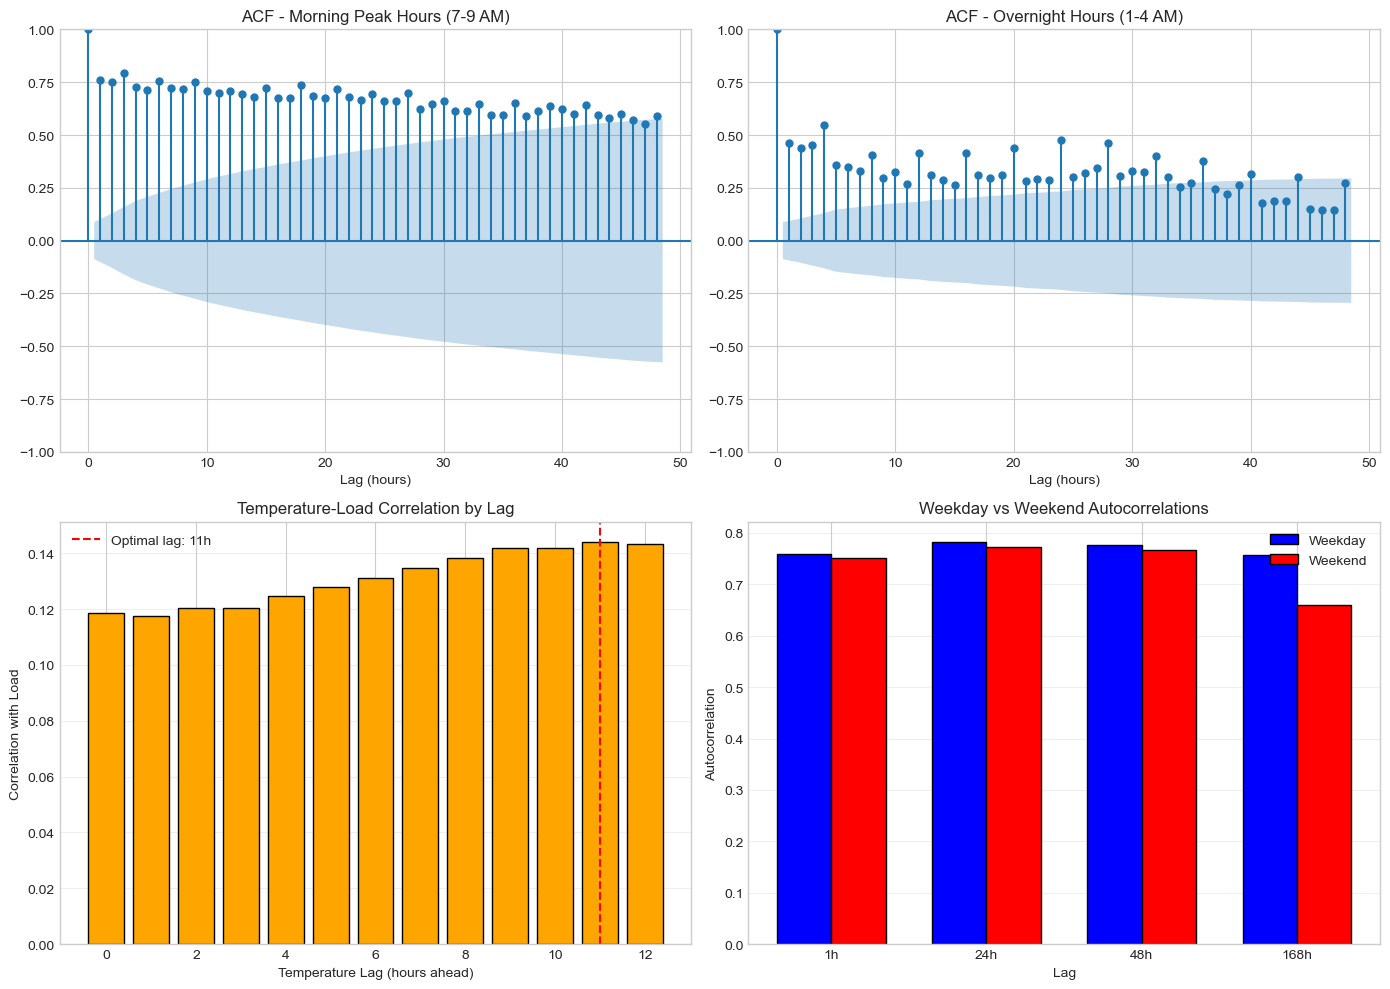

Lag Analysis Summary:
Morning peak shows stronger persistence than overnight
Optimal temperature lag: 11 hours (temperature leads load)
Weekend patterns show weaker 24h correlation (0.773) vs weekday (0.783)

Recommended lags for forecasting model:
- Lag 1 (1 hour): Captures short-term persistence
- Lag 24 (1 day): Captures daily patterns
- Lag 168 (1 week): Captures weekly patterns
- Temperature with 11-hour lead
- Consider separate models for weekday/weekend


In [11]:
# Solution
# 1. Autocorrelation by time of day
morning_peak = load_data[(load_data.index.hour >= 7) & (load_data.index.hour <= 9)]['load']
overnight = load_data[(load_data.index.hour >= 1) & (load_data.index.hour <= 4)]['load']

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Morning peak ACF
ax = axes[0, 0]
plot_acf(morning_peak[:500], lags=48, ax=ax)
ax.set_title('ACF - Morning Peak Hours (7-9 AM)')
ax.set_xlabel('Lag (hours)')

# Overnight ACF
ax = axes[0, 1]
plot_acf(overnight[:500], lags=48, ax=ax)
ax.set_title('ACF - Overnight Hours (1-4 AM)')
ax.set_xlabel('Lag (hours)')

# 2. Temperature lag analysis
ax = axes[1, 0]
lag_range = range(0, 13)  # 0-12 hours
temp_corr = []

for lag in lag_range:
    # Shift temperature backwards (temperature leads load)
    corr = load_data['load'].corr(load_data['temperature'].shift(-lag))
    temp_corr.append(corr)

ax.bar(lag_range, temp_corr, color='orange', edgecolor='black')
ax.set_xlabel('Temperature Lag (hours ahead)')
ax.set_ylabel('Correlation with Load')
ax.set_title('Temperature-Load Correlation by Lag')
ax.grid(True, alpha=0.3, axis='y')

optimal_lag = lag_range[np.argmax(np.abs(temp_corr))]
ax.axvline(x=optimal_lag, color='red', linestyle='--', label=f'Optimal lag: {optimal_lag}h')
ax.legend()

# 3. Weekday vs Weekend patterns
ax = axes[1, 1]
weekday_data = load_data[load_data['weekday'] < 5]['load']
weekend_data = load_data[load_data['weekday'] >= 5]['load']

lags_to_check = [1, 24, 48, 168]  # 1h, 1d, 2d, 1w
weekday_acf = [weekday_data.autocorr(lag=lag) for lag in lags_to_check]
weekend_acf = [weekend_data.autocorr(lag=lag) for lag in lags_to_check]

x = np.arange(len(lags_to_check))
width = 0.35

ax.bar(x - width/2, weekday_acf, width, label='Weekday', color='blue', edgecolor='black')
ax.bar(x + width/2, weekend_acf, width, label='Weekend', color='red', edgecolor='black')
ax.set_xlabel('Lag')
ax.set_ylabel('Autocorrelation')
ax.set_title('Weekday vs Weekend Autocorrelations')
ax.set_xticks(x)
ax.set_xticklabels(['1h', '24h', '48h', '168h'])
ax.legend()
ax.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

# 4. Identify best lags for forecasting
print("Lag Analysis Summary:")
print(f"Morning peak shows stronger persistence than overnight")
print(f"Optimal temperature lag: {optimal_lag} hours (temperature leads load)")
print(f"Weekend patterns show weaker 24h correlation ({weekend_acf[1]:.3f}) vs weekday ({weekday_acf[1]:.3f})")

print("\nRecommended lags for forecasting model:")
print("- Lag 1 (1 hour): Captures short-term persistence")
print("- Lag 24 (1 day): Captures daily patterns")
print("- Lag 168 (1 week): Captures weekly patterns")
print(f"- Temperature with {optimal_lag}-hour lead")
print("- Consider separate models for weekday/weekend")

## 4. Basic Forecasting Methods

Now let's implement practical forecasting methods commonly used in power system operations. We'll start with simple methods and progress to more sophisticated approaches.

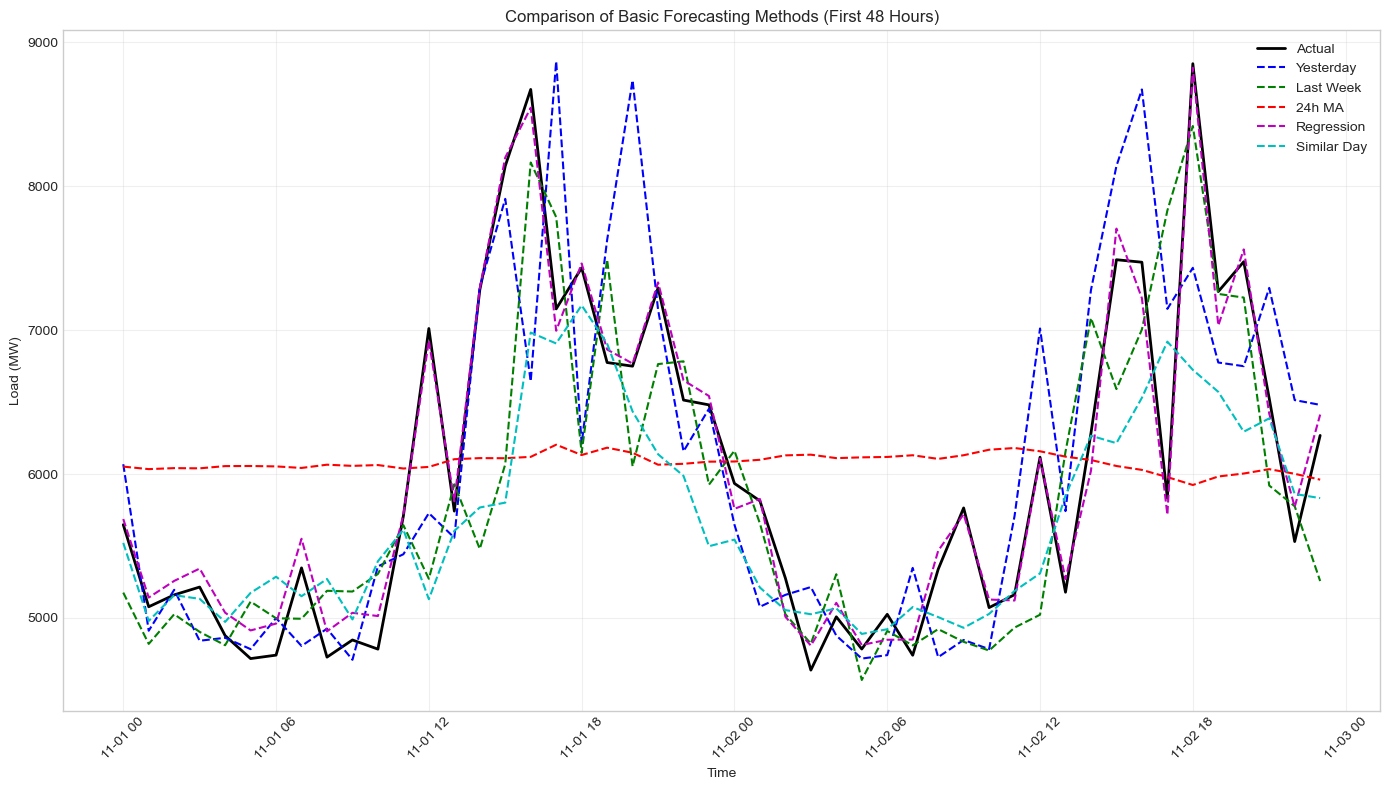

Forecast Method Performance (Full Week):
--------------------------------------------------
naive           MAE: 1208.1 MW  RMSE: 1359.6 MW  MAPE: 21.82%
yesterday       MAE:  660.5 MW  RMSE:  936.9 MW  MAPE: 10.48%
last_week       MAE:  620.3 MW  RMSE:  860.8 MW  MAPE:  9.73%
ma_24h          MAE: 1061.9 MW  RMSE: 1256.0 MW  MAPE: 17.78%
regression      MAE:  196.8 MW  RMSE:  235.6 MW  MAPE:  3.54%
similar_day     MAE:  626.0 MW  RMSE:  899.3 MW  MAPE:  9.40%


In [12]:
# Implement basic forecasting methods
# Use October 2023 data for training, forecast first week of November

# Prepare data
train_data = load_data.loc['2023-10']
test_data = load_data.loc['2023-11-01':'2023-11-07']

# Store forecasts
forecasts = pd.DataFrame(index=test_data.index)
forecasts['actual'] = test_data['load']

# Method 1: Naive (persistence) forecast
forecasts['naive'] = train_data['load'].iloc[-1]

# Method 2: Yesterday same time
forecasts['yesterday'] = np.nan
for i in range(len(test_data)):
    if i >= 24:
        forecasts['yesterday'].iloc[i] = forecasts['actual'].iloc[i-24]
    else:
        # Use last days of training
        forecasts['yesterday'].iloc[i] = train_data['load'].iloc[-(24-i)]

# Method 3: Last week same time
forecasts['last_week'] = np.nan
for i in range(len(test_data)):
    forecasts['last_week'].iloc[i] = train_data['load'].iloc[-(168-i)]

# Method 4: Moving average (24-hour)
window_size = 24
forecasts['ma_24h'] = np.nan
# Initialize with training data
recent_values = list(train_data['load'].iloc[-window_size:])

for i in range(len(test_data)):
    forecasts['ma_24h'].iloc[i] = np.mean(recent_values)
    # Update window with actual value (in practice, would use forecast)
    recent_values.pop(0)
    recent_values.append(test_data['load'].iloc[i])

# Method 5: Simple regression with temperature
# Create features
train_features = pd.DataFrame({
    'hour': train_data.index.hour,
    'weekday': train_data.index.weekday,
    'temperature': train_data['temperature'],
    'temp_squared': train_data['temperature'] ** 2
})
train_target = train_data['load']

test_features = pd.DataFrame({
    'hour': test_data.index.hour,
    'weekday': test_data.index.weekday,
    'temperature': test_data['temperature'],
    'temp_squared': test_data['temperature'] ** 2
})

# Fit model
model = LinearRegression()
model.fit(train_features, train_target)
forecasts['regression'] = model.predict(test_features)

# Method 6: Similar day approach
forecasts['similar_day'] = np.nan
for i, timestamp in enumerate(test_data.index):
    # Find similar days (same hour, same day of week)
    similar_mask = (train_data.index.hour == timestamp.hour) & \
                   (train_data.index.weekday == timestamp.weekday())
    similar_loads = train_data.loc[similar_mask, 'load']
    
    if len(similar_loads) > 0:
        forecasts['similar_day'].iloc[i] = similar_loads.mean()

# Visualize first 48 hours of forecasts
plt.figure(figsize=(14, 8))
hours_to_plot = 48
time_index = forecasts.index[:hours_to_plot]

plt.plot(time_index, forecasts['actual'][:hours_to_plot], 'k-', linewidth=2, label='Actual')
plt.plot(time_index, forecasts['yesterday'][:hours_to_plot], 'b--', label='Yesterday')
plt.plot(time_index, forecasts['last_week'][:hours_to_plot], 'g--', label='Last Week')
plt.plot(time_index, forecasts['ma_24h'][:hours_to_plot], 'r--', label='24h MA')
plt.plot(time_index, forecasts['regression'][:hours_to_plot], 'm--', label='Regression')
plt.plot(time_index, forecasts['similar_day'][:hours_to_plot], 'c--', label='Similar Day')

plt.xlabel('Time')
plt.ylabel('Load (MW)')
plt.title('Comparison of Basic Forecasting Methods (First 48 Hours)')
plt.legend(loc='upper right')
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Calculate errors for each method
print("Forecast Method Performance (Full Week):")
print("-" * 50)

methods = ['naive', 'yesterday', 'last_week', 'ma_24h', 'regression', 'similar_day']
for method in methods:
    mae = mean_absolute_error(forecasts['actual'], forecasts[method])
    rmse = np.sqrt(mean_squared_error(forecasts['actual'], forecasts[method]))
    mape = np.mean(np.abs((forecasts['actual'] - forecasts[method]) / forecasts['actual'])) * 100
    
    print(f"{method.ljust(15)} MAE: {mae:6.1f} MW  RMSE: {rmse:6.1f} MW  MAPE: {mape:5.2f}%")

```{admonition} Exercise 4: Implement a Day-Ahead Peak Load Forecast
:class: tip

Create a forecasting system that predicts tomorrow's peak load (maximum hourly load). Your system should:

1. Use multiple forecasting methods
2. Consider temperature forecasts
3. Account for day-of-week effects
4. Combine forecasts using weighted averaging
5. Report the predicted peak hour and magnitude

Test your system on multiple days and evaluate accuracy.
```

In [13]:
# Exercise 4: Your code here
# Implement day-ahead peak load forecasting

# Your solution:

Peak Load Forecast Results:
Date         Forecast   Actual     Error      Hour Forecast   Hour Actual  Hour Error
--------------------------------------------------------------------------------
2023-11-01       7288 MW      8673 MW    -1385 MW             18:00          16:00         2h
2023-11-02       7252 MW      8852 MW    -1600 MW             17:00          18:00         1h
2023-11-03       6908 MW      8843 MW    -1936 MW             17:00          19:00         2h
2023-11-04       7135 MW      7439 MW     -304 MW             18:00          21:00         3h
2023-11-05       6883 MW      8485 MW    -1602 MW             18:00          18:00         0h
2023-11-06       7514 MW      8794 MW    -1279 MW             18:00          16:00         2h
2023-11-07       7523 MW      9006 MW    -1483 MW             17:00          16:00         1h

Summary Statistics:
MAE: 1369.7 MW
RMSE: 1450.0 MW
MAPE: 15.70%
Average hour error: 1.6 hours


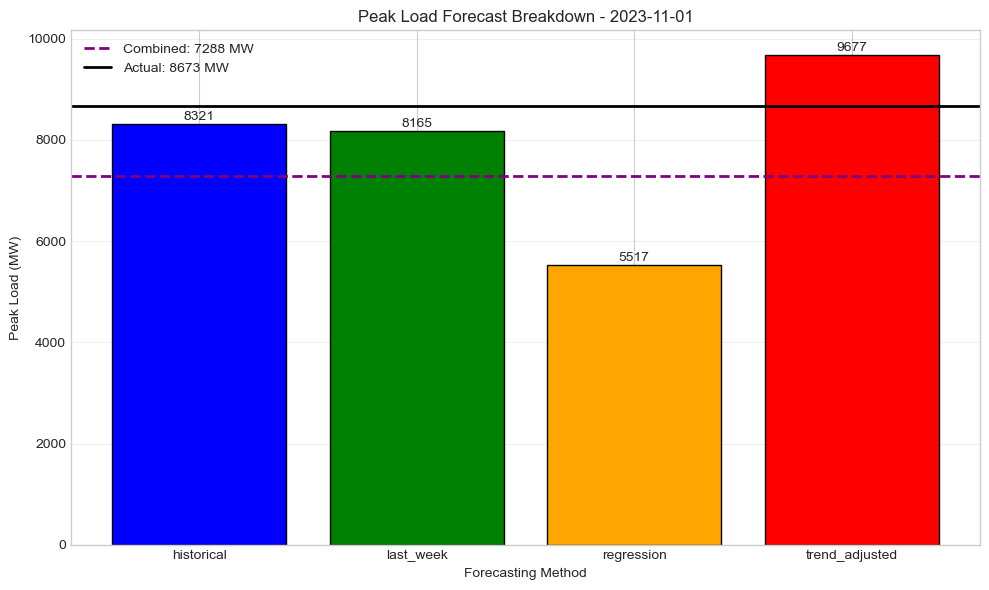

In [14]:
# Solution
def forecast_peak_load(train_data, forecast_date, temperature_forecast=None):
    """
    Forecast peak load for a given date using multiple methods
    
    Parameters:
    train_data: Historical load data
    forecast_date: Date to forecast (datetime)
    temperature_forecast: Optional temperature forecast for the day
    
    Returns:
    dict with peak_hour, peak_load, and method details
    """
    
    # Get day of week
    dow = forecast_date.weekday()
    
    # Method 1: Historical average for same day of week
    hist_peaks = []
    for d in pd.date_range(end=forecast_date - pd.Timedelta(days=1), periods=28, freq='D'):
        if d.weekday() == dow and d in train_data.index:
            daily_data = train_data.loc[d.strftime('%Y-%m-%d')]
            if len(daily_data) > 0:
                peak_hour = daily_data['load'].idxmax().hour
                peak_value = daily_data['load'].max()
                hist_peaks.append((peak_hour, peak_value))
    
    if hist_peaks:
        avg_peak_hour = int(np.mean([p[0] for p in hist_peaks]))
        method1_peak = np.mean([p[1] for p in hist_peaks])
    else:
        avg_peak_hour = 17  # Default peak hour
        method1_peak = train_data['load'].mean() * 1.2
    
    # Method 2: Last week same day
    last_week_date = forecast_date - pd.Timedelta(days=7)
    if last_week_date.strftime('%Y-%m-%d') in train_data.index:
        last_week_data = train_data.loc[last_week_date.strftime('%Y-%m-%d')]
        method2_peak = last_week_data['load'].max()
        method2_hour = last_week_data['load'].idxmax().hour
    else:
        method2_peak = method1_peak
        method2_hour = avg_peak_hour
    
    # Method 3: Regression-based
    # Prepare features for peak hours (typically 16-20)
    peak_hours = range(16, 21)
    features = []
    
    for hour in peak_hours:
        feature = {
            'hour': hour,
            'weekday': dow,
            'is_weekend': 1 if dow >= 5 else 0,
            'month': forecast_date.month,
        }
        
        # Add temperature if available
        if temperature_forecast is not None:
            feature['temp'] = temperature_forecast.get(hour, 20)  # Default 20°C
            feature['temp_sq'] = feature['temp'] ** 2
        else:
            # Use historical average temperature
            hist_temps = train_data[(train_data.index.hour == hour) & 
                                   (train_data.index.weekday == dow)]['temperature']
            feature['temp'] = hist_temps.mean() if len(hist_temps) > 0 else 20
            feature['temp_sq'] = feature['temp'] ** 2
        
        features.append(feature)
    
    # Train model on historical peak hour data
    train_features = []
    train_targets = []
    
    for idx in train_data.index:
        if idx.hour in peak_hours:
            train_features.append({
                'hour': idx.hour,
                'weekday': idx.weekday(),
                'is_weekend': 1 if idx.weekday() >= 5 else 0,
                'month': idx.month,
                'temp': train_data.loc[idx, 'temperature'],
                'temp_sq': train_data.loc[idx, 'temperature'] ** 2
            })
            train_targets.append(train_data.loc[idx, 'load'])
    
    X_train = pd.DataFrame(train_features)
    y_train = np.array(train_targets)
    
    model = LinearRegression()
    model.fit(X_train, y_train)
    
    # Predict for peak hours
    X_forecast = pd.DataFrame(features)
    predictions = model.predict(X_forecast)
    
    method3_idx = np.argmax(predictions)
    method3_peak = predictions[method3_idx]
    method3_hour = peak_hours[method3_idx]
    
    # Method 4: Trend-adjusted similar day
    # Find trend over last 7 days
    recent_peaks = []
    for i in range(1, 8):
        date = forecast_date - pd.Timedelta(days=i)
        if date.strftime('%Y-%m-%d') in train_data.index:
            daily_max = train_data.loc[date.strftime('%Y-%m-%d')]['load'].max()
            recent_peaks.append(daily_max)
    
    if len(recent_peaks) >= 3:
        trend = np.polyfit(range(len(recent_peaks)), recent_peaks, 1)[0]
        method4_peak = method2_peak + trend * 7  # Extrapolate trend
    else:
        method4_peak = method2_peak
    
    # Combine forecasts with weights
    weights = {
        'historical': 0.2,
        'last_week': 0.3,
        'regression': 0.4,
        'trend': 0.1
    }
    
    combined_peak = (
        weights['historical'] * method1_peak +
        weights['last_week'] * method2_peak +
        weights['regression'] * method3_peak +
        weights['trend'] * method4_peak
    )
    
    # Determine most likely peak hour (weighted average)
    hour_votes = {
        avg_peak_hour: weights['historical'],
        method2_hour: weights['last_week'],
        method3_hour: weights['regression']
    }
    
    peak_hour = max(hour_votes, key=hour_votes.get)
    
    return {
        'date': forecast_date,
        'peak_hour': peak_hour,
        'peak_load': combined_peak,
        'methods': {
            'historical': method1_peak,
            'last_week': method2_peak,
            'regression': method3_peak,
            'trend_adjusted': method4_peak
        },
        'weights': weights
    }

# Test the system on multiple days
test_dates = pd.date_range(start='2023-11-01', end='2023-11-07', freq='D')
results = []

for test_date in test_dates:
    # Use data up to day before
    train_end = test_date - pd.Timedelta(days=1)
    train_subset = load_data[:train_end]
    
    # Forecast
    forecast = forecast_peak_load(train_subset, test_date)
    
    # Get actual
    actual_data = load_data.loc[test_date.strftime('%Y-%m-%d')]
    actual_peak = actual_data['load'].max()
    actual_peak_hour = actual_data['load'].idxmax().hour
    
    # Store results
    forecast['actual_peak'] = actual_peak
    forecast['actual_peak_hour'] = actual_peak_hour
    forecast['error_mw'] = forecast['peak_load'] - actual_peak
    forecast['error_pct'] = (forecast['peak_load'] - actual_peak) / actual_peak * 100
    forecast['hour_error'] = abs(forecast['peak_hour'] - actual_peak_hour)
    
    results.append(forecast)

# Display results
print("Peak Load Forecast Results:")
print("=" * 80)
print(f"{'Date':<12} {'Forecast':<10} {'Actual':<10} {'Error':<10} {'Hour Forecast':<15} {'Hour Actual':<12} {'Hour Error':<10}")
print("-" * 80)

for r in results:
    print(f"{r['date'].strftime('%Y-%m-%d'):<12} "
          f"{r['peak_load']:>8.0f} MW  "
          f"{r['actual_peak']:>8.0f} MW  "
          f"{r['error_mw']:>7.0f} MW  "
          f"{r['peak_hour']:>13d}:00  "
          f"{r['actual_peak_hour']:>10d}:00  "
          f"{r['hour_error']:>8d}h")

# Summary statistics
errors_mw = [r['error_mw'] for r in results]
errors_pct = [r['error_pct'] for r in results]
hour_errors = [r['hour_error'] for r in results]

print("\nSummary Statistics:")
print(f"MAE: {np.mean(np.abs(errors_mw)):.1f} MW")
print(f"RMSE: {np.sqrt(np.mean(np.array(errors_mw)**2)):.1f} MW")
print(f"MAPE: {np.mean(np.abs(errors_pct)):.2f}%")
print(f"Average hour error: {np.mean(hour_errors):.1f} hours")

# Visualize one day's forecast breakdown
example_forecast = results[0]
methods = list(example_forecast['methods'].keys())
values = list(example_forecast['methods'].values())

plt.figure(figsize=(10, 6))
bars = plt.bar(methods, values, color=['blue', 'green', 'orange', 'red'], edgecolor='black')
plt.axhline(y=example_forecast['peak_load'], color='purple', linestyle='--', 
            linewidth=2, label=f"Combined: {example_forecast['peak_load']:.0f} MW")
plt.axhline(y=example_forecast['actual_peak'], color='black', linestyle='-', 
            linewidth=2, label=f"Actual: {example_forecast['actual_peak']:.0f} MW")

plt.xlabel('Forecasting Method')
plt.ylabel('Peak Load (MW)')
plt.title(f"Peak Load Forecast Breakdown - {example_forecast['date'].strftime('%Y-%m-%d')}")
plt.legend()
plt.grid(True, alpha=0.3, axis='y')

# Add value labels on bars
for bar, value in zip(bars, values):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 20, 
             f'{value:.0f}', ha='center', va='bottom')

plt.tight_layout()
plt.show()

## 5. Forecast Evaluation

Proper evaluation of forecast accuracy is crucial for system operators to understand the reliability of their predictions and plan appropriate reserves.

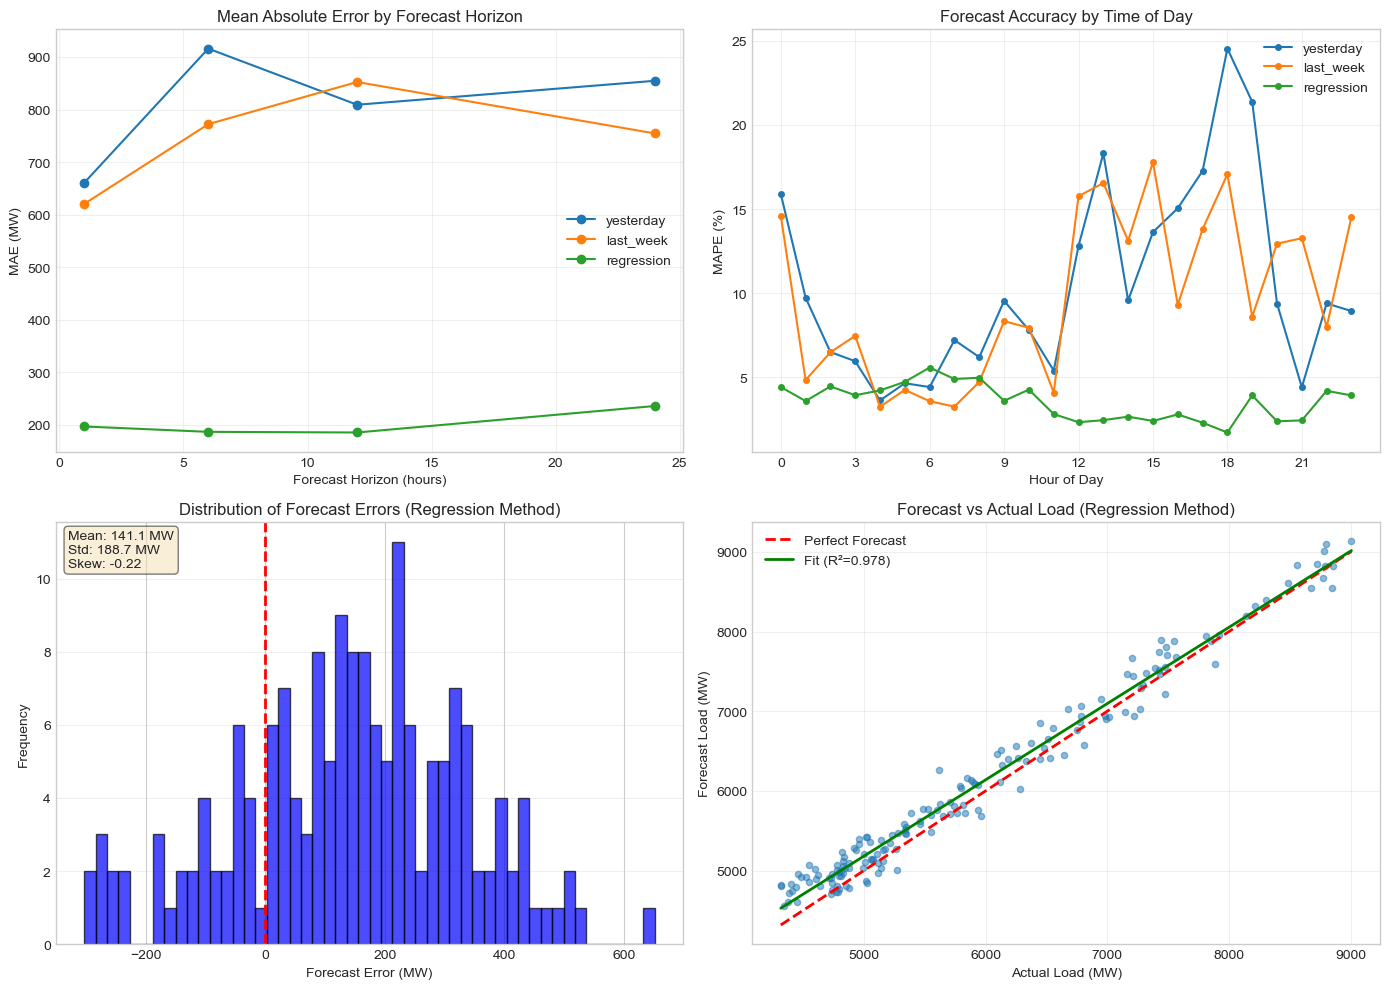


Peak Hour Forecast Accuracy:
--------------------------------------------------
yesterday       Peak MAPE: 21.05%  Off-Peak MAPE:  8.97%
last_week       Peak MAPE: 13.16%  Off-Peak MAPE:  9.24%
regression      Peak MAPE:  2.65%  Off-Peak MAPE:  3.67%


In [15]:
methods = ['naive', 'yesterday', 'last_week', 'ma_24h', 'regression', 'similar_day']

# Comprehensive forecast evaluation
# Let's evaluate forecasts at different time horizons

def evaluate_forecasts_by_horizon(forecasts, actuals, horizons=[1, 6, 12, 24]):
    """
    Evaluate forecast accuracy by time horizon
    """
    results = {}
    
    for h in horizons:
        # Get forecast/actual pairs for this horizon
        forecast_h = forecasts.iloc[::h]
        actual_h = actuals.iloc[::h]
        
        # Calculate metrics
        errors = forecast_h - actual_h
        mae = np.mean(np.abs(errors))
        rmse = np.sqrt(np.mean(errors**2))
        mape = np.mean(np.abs(errors / actual_h)) * 100
        
        # Bias (systematic over/under forecasting)
        bias = np.mean(errors)
        
        results[h] = {
            'MAE': mae,
            'RMSE': rmse,
            'MAPE': mape,
            'Bias': bias,
            'Count': len(errors)
        }
    
    return results

# Evaluate different methods by horizon
horizon_results = {}
for method in methods:
    horizon_results[method] = evaluate_forecasts_by_horizon(
        forecasts[method], 
        forecasts['actual']
    )

# Visualize results
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# 1. MAE by horizon
ax = axes[0, 0]
horizons = [1, 6, 12, 24]
for method in ['yesterday', 'last_week', 'regression']:
    mae_values = [horizon_results[method][h]['MAE'] for h in horizons]
    ax.plot(horizons, mae_values, marker='o', label=method)

ax.set_xlabel('Forecast Horizon (hours)')
ax.set_ylabel('MAE (MW)')
ax.set_title('Mean Absolute Error by Forecast Horizon')
ax.legend()
ax.grid(True, alpha=0.3)

# 2. MAPE by time of day
ax = axes[0, 1]
hourly_mape = {}
for hour in range(24):
    hour_mask = forecasts.index.hour == hour
    hourly_mape[hour] = {}
    
    for method in ['yesterday', 'last_week', 'regression']:
        if hour_mask.sum() > 0:
            errors = np.abs((forecasts.loc[hour_mask, method] - 
                           forecasts.loc[hour_mask, 'actual']) / 
                          forecasts.loc[hour_mask, 'actual'])
            hourly_mape[hour][method] = np.mean(errors) * 100

hours = list(range(24))
for method in ['yesterday', 'last_week', 'regression']:
    mape_by_hour = [hourly_mape[h][method] for h in hours]
    ax.plot(hours, mape_by_hour, marker='o', markersize=4, label=method)

ax.set_xlabel('Hour of Day')
ax.set_ylabel('MAPE (%)')
ax.set_title('Forecast Accuracy by Time of Day')
ax.legend()
ax.grid(True, alpha=0.3)
ax.set_xticks(range(0, 24, 3))

# 3. Error distribution
ax = axes[1, 0]
errors_regression = forecasts['regression'] - forecasts['actual']
ax.hist(errors_regression, bins=50, alpha=0.7, color='blue', edgecolor='black')
ax.axvline(x=0, color='red', linestyle='--', linewidth=2)
ax.set_xlabel('Forecast Error (MW)')
ax.set_ylabel('Frequency')
ax.set_title('Distribution of Forecast Errors (Regression Method)')
ax.grid(True, alpha=0.3, axis='y')

# Add statistics
textstr = f'Mean: {np.mean(errors_regression):.1f} MW\n'
textstr += f'Std: {np.std(errors_regression):.1f} MW\n'
textstr += f'Skew: {errors_regression.skew():.2f}'
ax.text(0.02, 0.98, textstr, transform=ax.transAxes, 
        verticalalignment='top', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

# 4. Forecast vs Actual scatter plot
ax = axes[1, 1]
sample_size = min(500, len(forecasts))
indices = np.random.choice(len(forecasts), sample_size, replace=False)

ax.scatter(forecasts.iloc[indices]['actual'], 
          forecasts.iloc[indices]['regression'], 
          alpha=0.5, s=20)

# Add perfect forecast line
min_val = forecasts['actual'].min()
max_val = forecasts['actual'].max()
ax.plot([min_val, max_val], [min_val, max_val], 'r--', linewidth=2, label='Perfect Forecast')

# Add regression line
from scipy import stats
slope, intercept, r_value, _, _ = stats.linregress(
    forecasts.iloc[indices]['actual'], 
    forecasts.iloc[indices]['regression']
)
x_reg = np.array([min_val, max_val])
y_reg = slope * x_reg + intercept
ax.plot(x_reg, y_reg, 'g-', linewidth=2, label=f'Fit (R²={r_value**2:.3f})')

ax.set_xlabel('Actual Load (MW)')
ax.set_ylabel('Forecast Load (MW)')
ax.set_title('Forecast vs Actual Load (Regression Method)')
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Peak hour accuracy analysis
print("\nPeak Hour Forecast Accuracy:")
print("-" * 50)

peak_hours = [17, 18, 19]  # Typical peak hours
peak_mask = forecasts.index.hour.isin(peak_hours)
off_peak_mask = ~peak_mask

for method in ['yesterday', 'last_week', 'regression']:
    peak_mape = np.mean(np.abs((forecasts.loc[peak_mask, method] - 
                               forecasts.loc[peak_mask, 'actual']) / 
                              forecasts.loc[peak_mask, 'actual'])) * 100
    
    off_peak_mape = np.mean(np.abs((forecasts.loc[off_peak_mask, method] - 
                                   forecasts.loc[off_peak_mask, 'actual']) / 
                                  forecasts.loc[off_peak_mask, 'actual'])) * 100
    
    print(f"{method.ljust(15)} Peak MAPE: {peak_mape:5.2f}%  Off-Peak MAPE: {off_peak_mape:5.2f}%")

## 6. Practical Considerations

Real-world forecasting faces many challenges beyond statistical modeling. Let's explore common issues and solutions.

Missing Data Analysis:
Total missing values: 358
Percentage missing: 2.0%


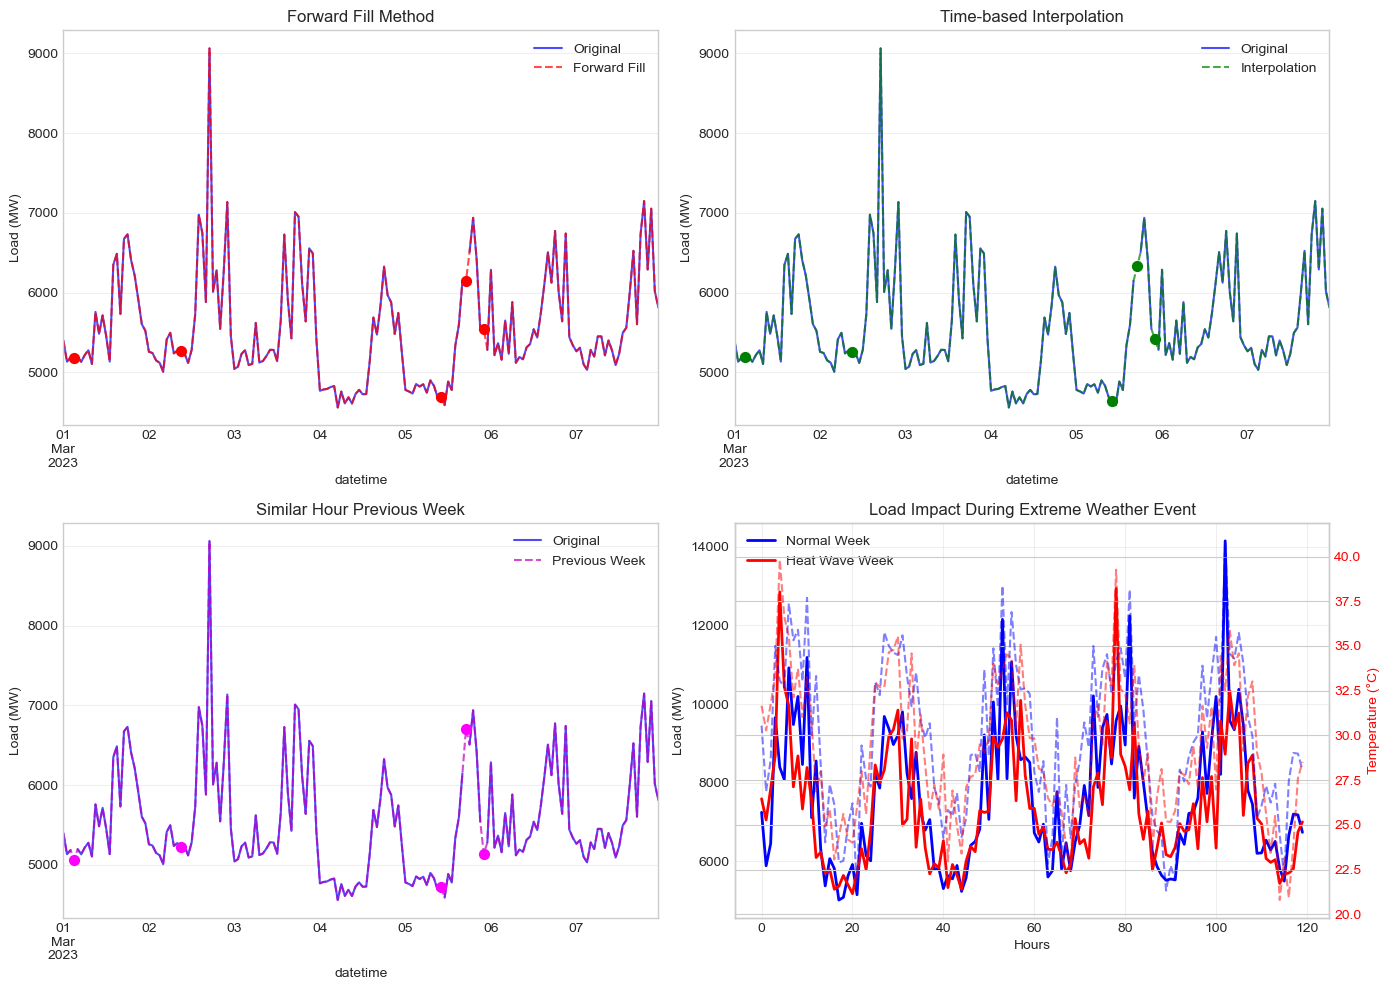


Behind-the-Meter Solar Impact Analysis:
Average midday load without solar: 6508 MW
Estimated solar impact: 325 MW
This represents hidden load that affects forecast accuracy

Detected 37 potential holidays/special days
Examples:
  2022-02-27 (Sunday): 5070 MW
  2022-03-06 (Sunday): 5073 MW
  2022-03-12 (Saturday): 4920 MW
  2022-03-13 (Sunday): 4914 MW
  2022-03-19 (Saturday): 5013 MW


In [16]:
# Handling practical forecasting challenges

# 1. Missing data handling
# Introduce some missing values
load_with_missing = load_data.copy()
missing_mask = np.random.random(len(load_data)) < 0.02  # 2% missing
load_with_missing.loc[missing_mask, 'load'] = np.nan

print("Missing Data Analysis:")
print(f"Total missing values: {load_with_missing['load'].isna().sum()}")
print(f"Percentage missing: {load_with_missing['load'].isna().mean() * 100:.1f}%")

# Different imputation strategies
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Show a week with missing data
week_missing = load_with_missing.loc['2023-03-01':'2023-03-07']['load']

# Method 1: Forward fill
ax = axes[0, 0]
filled_forward = week_missing.fillna(method='ffill')
week_missing.plot(ax=ax, style='b-', label='Original', alpha=0.7)
filled_forward.plot(ax=ax, style='r--', label='Forward Fill', alpha=0.7)
ax.scatter(week_missing[week_missing.isna()].index, 
          filled_forward[week_missing.isna()], 
          color='red', s=50, zorder=5)
ax.set_title('Forward Fill Method')
ax.set_ylabel('Load (MW)')
ax.legend()
ax.grid(True, alpha=0.3)

# Method 2: Interpolation
ax = axes[0, 1]
filled_interp = week_missing.interpolate(method='time')
week_missing.plot(ax=ax, style='b-', label='Original', alpha=0.7)
filled_interp.plot(ax=ax, style='g--', label='Interpolation', alpha=0.7)
ax.scatter(week_missing[week_missing.isna()].index, 
          filled_interp[week_missing.isna()], 
          color='green', s=50, zorder=5)
ax.set_title('Time-based Interpolation')
ax.set_ylabel('Load (MW)')
ax.legend()
ax.grid(True, alpha=0.3)

# Method 3: Similar hour from previous week
ax = axes[1, 0]
filled_similar = week_missing.copy()
for idx in week_missing[week_missing.isna()].index:
    similar_idx = idx - pd.Timedelta(days=7)
    if similar_idx in load_with_missing.index:
        filled_similar[idx] = load_with_missing.loc[similar_idx, 'load']

week_missing.plot(ax=ax, style='b-', label='Original', alpha=0.7)
filled_similar.plot(ax=ax, style='m--', label='Previous Week', alpha=0.7)
ax.scatter(week_missing[week_missing.isna()].index, 
          filled_similar[week_missing.isna()], 
          color='magenta', s=50, zorder=5)
ax.set_title('Similar Hour Previous Week')
ax.set_ylabel('Load (MW)')
ax.legend()
ax.grid(True, alpha=0.3)

# 2. Extreme weather event impact
ax = axes[1, 1]

# Use 5-day periods for comparison
normal_start = pd.Timestamp('2023-07-01')
normal_end = pd.Timestamp('2023-07-05 23:59:59')  # 5 full days
heat_wave_start = pd.Timestamp('2023-07-15')
heat_wave_end = pd.Timestamp('2023-07-19 23:59:59')  # 5 full days

# Extract periods
heat_wave_data = load_data[heat_wave_start:heat_wave_end].copy()
normal_week = load_data[normal_start:normal_end].copy()

# Plot comparison
hours = range(len(normal_week))
ax.plot(hours, normal_week['load'], 'b-', label='Normal Week', linewidth=2)
ax.plot(hours, heat_wave_data['load'], 'r-', label='Heat Wave Week', linewidth=2)

# Add temperature on secondary axis
ax2 = ax.twinx()
ax2.plot(hours, normal_week['temperature'], 'b--', alpha=0.5, label='Normal Temp')
ax2.plot(hours, heat_wave_data['temperature'], 'r--', alpha=0.5, label='Heat Wave Temp')
ax2.set_ylabel('Temperature (°C)', color='red')
ax2.tick_params(axis='y', labelcolor='red')

ax.set_xlabel('Hours')
ax.set_ylabel('Load (MW)')
ax.set_title('Load Impact During Extreme Weather Event')
ax.legend(loc='upper left')
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# 3. Behind-the-meter solar impact
print("\nBehind-the-Meter Solar Impact Analysis:")

# Simulate solar reduction effect (simplified)
solar_hours = (load_data.index.hour >= 10) & (load_data.index.hour <= 16)
summer_days = load_data.index.month.isin([6, 7, 8])

# Calculate apparent load reduction
solar_mask = solar_hours & summer_days
avg_reduction = load_data.loc[solar_mask, 'load'].mean() * 0.05  # 5% reduction

print(f"Average midday load without solar: {load_data.loc[solar_mask, 'load'].mean():.0f} MW")
print(f"Estimated solar impact: {avg_reduction:.0f} MW")
print(f"This represents hidden load that affects forecast accuracy")

# 4. Holiday detection and handling
# Simple holiday detection based on low load
daily_avg = load_data.resample('D')['load'].mean()
threshold = daily_avg.quantile(0.05)
potential_holidays = daily_avg[daily_avg < threshold]

print(f"\nDetected {len(potential_holidays)} potential holidays/special days")
print("Examples:")
for date, load in list(potential_holidays.items())[:5]:
    day_name = date.strftime('%A')
    print(f"  {date.strftime('%Y-%m-%d')} ({day_name}): {load:.0f} MW")

```{admonition} Exercise 5: Build a Complete Forecasting System
:class: tip

Create a simple load forecasting system that:

1. Handles missing data appropriately
2. Detects and flags holidays/special events
3. Combines multiple forecasting methods
4. Provides uncertainty estimates
5. Generates a forecast report

Test your system with real-world scenarios including missing data and holidays.
```

In [17]:
# Exercise 5: Your code here
# Build a complete forecasting system

# Your solution:

Filled 100 missing values using interpolate
Detected 37 potential holidays
LOAD FORECAST REPORT
Forecast Period: 2023-11-01 00:00:00 to 2023-11-07 23:00:00
Number of Hours: 168

Forecast Summary:
  Average Load: 5595 MW
  Peak Load: 6549 MW
  Peak Hour: 2023-11-06 17:00:00
  Min Load: 4835 MW

Uncertainty Analysis (95% confidence):
  Average Uncertainty: ±1313 MW
  Max Uncertainty: ±2009 MW

Forecast Accuracy:
  MAE: 869.5 MW
  RMSE: 1126.2 MW
  MAPE: 13.54%


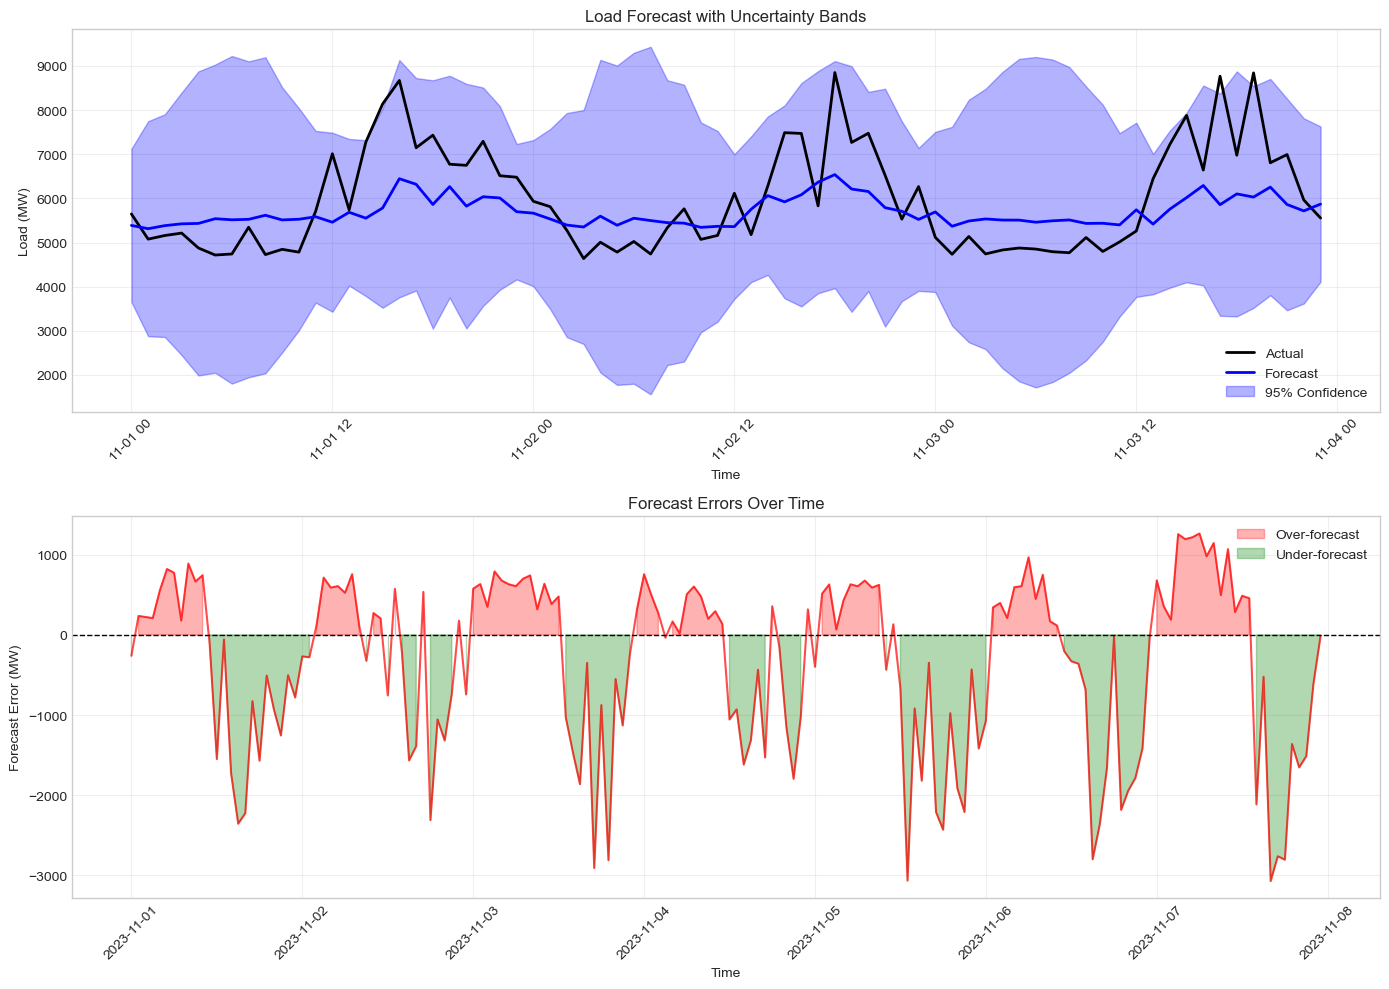

In [18]:
# Solution
class LoadForecastingSystem:
    """
    Complete load forecasting system with practical features
    """
    
    def __init__(self, historical_data):
        self.data = historical_data.copy()
        self.holidays = []
        self.models = {}
        
    def detect_holidays(self, threshold_percentile=5):
        """Detect potential holidays based on low load"""
        daily_avg = self.data.resample('D')['load'].mean()
        threshold = daily_avg.quantile(threshold_percentile / 100)
        self.holidays = daily_avg[daily_avg < threshold].index.tolist()
        return self.holidays
    
    def handle_missing_data(self, method='interpolate'):
        """Handle missing values in the data"""
        missing_count = self.data['load'].isna().sum()
        
        if missing_count > 0:
            if method == 'interpolate':
                self.data['load'] = self.data['load'].interpolate(method='time')
            elif method == 'forward_fill':
                self.data['load'] = self.data['load'].fillna(method='ffill')
            elif method == 'similar_hour':
                # Fill with same hour from previous week
                for idx in self.data[self.data['load'].isna()].index:
                    prev_week = idx - pd.Timedelta(days=7)
                    if prev_week in self.data.index:
                        self.data.loc[idx, 'load'] = self.data.loc[prev_week, 'load']
            
            print(f"Filled {missing_count} missing values using {method}")
    
    def train_models(self, train_end_date):
        """Train multiple forecasting models"""
        train_data = self.data[:train_end_date]
        
        # Model 1: Linear Regression
        features = pd.DataFrame({
            'hour': train_data.index.hour,
            'weekday': train_data.index.weekday,
            'month': train_data.index.month,
            'is_weekend': (train_data.index.weekday >= 5).astype(int),
            'temperature': train_data['temperature'],
            'temp_squared': train_data['temperature'] ** 2
        })
        
        self.models['regression'] = LinearRegression()
        self.models['regression'].fit(features, train_data['load'])
        
        # Store training data for other methods
        self.train_data = train_data
        
    def forecast(self, forecast_dates, confidence_level=0.95):
        """Generate forecasts with uncertainty estimates"""
        results = pd.DataFrame(index=forecast_dates)
        
        # Check if forecast date is a holiday
        results['is_holiday'] = results.index.normalize().isin(self.holidays)
        
        # Method 1: Regression
        features = pd.DataFrame({
            'hour': forecast_dates.hour,
            'weekday': forecast_dates.weekday,
            'month': forecast_dates.month,
            'is_weekend': (forecast_dates.weekday >= 5).astype(int),
            'temperature': 20,  # Default temperature
            'temp_squared': 400
        })
        results['regression'] = self.models['regression'].predict(features)
        
        # Method 2: Similar day
        similar_day_forecasts = []
        for date in forecast_dates:
            if results.loc[date, 'is_holiday']:
                # Use average of past holidays
                holiday_loads = []
                for holiday in self.holidays:
                    if holiday < date and date.hour in self.train_data.index.hour:
                        holiday_data = self.train_data[holiday.strftime('%Y-%m-%d')]
                        holiday_hour_data = holiday_data[holiday_data.index.hour == date.hour]
                        if len(holiday_hour_data) > 0:
                            holiday_loads.append(holiday_hour_data['load'].mean())
                
                similar_day_forecasts.append(np.mean(holiday_loads) if holiday_loads else results.loc[date, 'regression'] * 0.85)
            else:
                # Normal similar day logic
                similar_days = self.train_data[
                    (self.train_data.index.hour == date.hour) & 
                    (self.train_data.index.weekday == date.weekday())
                ]['load']
                similar_day_forecasts.append(similar_days.mean() if len(similar_days) > 0 else results.loc[date, 'regression'])
        
        results['similar_day'] = similar_day_forecasts
        
        # Method 3: Last week
        last_week_forecasts = []
        for date in forecast_dates:
            last_week = date - pd.Timedelta(days=7)
            if last_week in self.train_data.index:
                last_week_forecasts.append(self.train_data.loc[last_week, 'load'])
            else:
                last_week_forecasts.append(results.loc[date, 'similar_day'])
        
        results['last_week'] = last_week_forecasts
        
        # Combine forecasts
        if results['is_holiday'].any():
            # Adjust weights for holidays
            results.loc[results['is_holiday'], 'combined'] = (
                0.2 * results.loc[results['is_holiday'], 'regression'] +
                0.6 * results.loc[results['is_holiday'], 'similar_day'] +
                0.2 * results.loc[results['is_holiday'], 'last_week']
            )
            results.loc[~results['is_holiday'], 'combined'] = (
                0.4 * results.loc[~results['is_holiday'], 'regression'] +
                0.3 * results.loc[~results['is_holiday'], 'similar_day'] +
                0.3 * results.loc[~results['is_holiday'], 'last_week']
            )
        else:
            results['combined'] = 0.4 * results['regression'] + 0.3 * results['similar_day'] + 0.3 * results['last_week']
        
        # Estimate uncertainty based on historical errors
        # Calculate standard deviation of errors for similar conditions
        uncertainty = []
        for date in forecast_dates:
            similar_conditions = self.train_data[
                (self.train_data.index.hour == date.hour) & 
                (self.train_data.index.weekday == date.weekday())
            ]['load']
            
            if len(similar_conditions) > 1:
                std_dev = similar_conditions.std()
            else:
                std_dev = self.train_data['load'].std() * 0.1  # Default to 10% of overall std
            
            uncertainty.append(std_dev)
        
        results['uncertainty'] = uncertainty
        
        # Calculate confidence intervals
        z_score = stats.norm.ppf((1 + confidence_level) / 2)
        results['lower_bound'] = results['combined'] - z_score * results['uncertainty']
        results['upper_bound'] = results['combined'] + z_score * results['uncertainty']
        
        return results
    
    def generate_report(self, forecast_results, actual_data=None):
        """Generate a forecast report"""
        report = []
        report.append("=" * 60)
        report.append("LOAD FORECAST REPORT")
        report.append("=" * 60)
        report.append(f"Forecast Period: {forecast_results.index[0]} to {forecast_results.index[-1]}")
        report.append(f"Number of Hours: {len(forecast_results)}")
        
        # Holiday information
        holiday_count = forecast_results['is_holiday'].sum()
        if holiday_count > 0:
            report.append(f"\nSpecial Days Detected: {holiday_count} hours")
            holiday_dates = forecast_results[forecast_results['is_holiday']].index.normalize().unique()
            for date in holiday_dates:
                report.append(f"  - {date.strftime('%Y-%m-%d (%A)')}")
        
        # Forecast summary
        report.append(f"\nForecast Summary:")
        report.append(f"  Average Load: {forecast_results['combined'].mean():.0f} MW")
        report.append(f"  Peak Load: {forecast_results['combined'].max():.0f} MW")
        report.append(f"  Peak Hour: {forecast_results['combined'].idxmax()}")
        report.append(f"  Min Load: {forecast_results['combined'].min():.0f} MW")
        
        # Uncertainty analysis
        report.append(f"\nUncertainty Analysis (95% confidence):")
        report.append(f"  Average Uncertainty: ±{forecast_results['uncertainty'].mean():.0f} MW")
        report.append(f"  Max Uncertainty: ±{forecast_results['uncertainty'].max():.0f} MW")
        
        # If actual data provided, calculate accuracy
        if actual_data is not None:
            errors = forecast_results['combined'] - actual_data['load']
            mae = np.mean(np.abs(errors))
            rmse = np.sqrt(np.mean(errors**2))
            mape = np.mean(np.abs(errors / actual_data['load'])) * 100
            
            report.append(f"\nForecast Accuracy:")
            report.append(f"  MAE: {mae:.1f} MW")
            report.append(f"  RMSE: {rmse:.1f} MW")
            report.append(f"  MAPE: {mape:.2f}%")
        
        return "\n".join(report)

# Test the system
# Create data with some missing values
test_data = load_data.copy()
missing_indices = np.random.choice(test_data.index, size=100, replace=False)
test_data.loc[missing_indices, 'load'] = np.nan

# Initialize system
forecast_system = LoadForecastingSystem(test_data)

# Handle missing data
forecast_system.handle_missing_data(method='interpolate')

# Detect holidays
holidays = forecast_system.detect_holidays()
print(f"Detected {len(holidays)} potential holidays")

# Train models
train_end = pd.Timestamp('2023-10-31')
forecast_system.train_models(train_end)

# Generate forecast for first week of November
forecast_dates = pd.date_range(start='2023-11-01', end='2023-11-07 23:00:00', freq='H')
forecast_results = forecast_system.forecast(forecast_dates)

# Get actual data for comparison
actual_data = load_data['2023-11-01':'2023-11-07']

# Generate report
report = forecast_system.generate_report(forecast_results, actual_data)
print(report)

# Visualize results
fig, axes = plt.subplots(2, 1, figsize=(14, 10))

# Plot 1: Forecast with confidence intervals
ax = axes[0]
hours_to_plot = 72  # First 3 days
time_index = forecast_results.index[:hours_to_plot]

ax.plot(time_index, actual_data['load'][:hours_to_plot], 'k-', linewidth=2, label='Actual')
ax.plot(time_index, forecast_results['combined'][:hours_to_plot], 'b-', linewidth=2, label='Forecast')
ax.fill_between(time_index, 
                forecast_results['lower_bound'][:hours_to_plot],
                forecast_results['upper_bound'][:hours_to_plot],
                alpha=0.3, color='blue', label='95% Confidence')

# Mark holidays
holiday_mask = forecast_results['is_holiday'][:hours_to_plot]
if holiday_mask.any():
    ax.scatter(time_index[holiday_mask], 
              forecast_results.loc[holiday_mask, 'combined'][:hours_to_plot],
              color='red', s=50, marker='*', zorder=5, label='Holiday Hours')

ax.set_xlabel('Time')
ax.set_ylabel('Load (MW)')
ax.set_title('Load Forecast with Uncertainty Bands')
ax.legend()
ax.grid(True, alpha=0.3)
ax.tick_params(axis='x', rotation=45)

# Plot 2: Forecast errors
ax = axes[1]
errors = forecast_results['combined'] - actual_data['load']
ax.plot(forecast_results.index, errors, 'r-', alpha=0.7)
ax.axhline(y=0, color='k', linestyle='--', linewidth=1)
ax.fill_between(forecast_results.index, errors, 0, 
                where=(errors > 0), color='red', alpha=0.3, label='Over-forecast')
ax.fill_between(forecast_results.index, errors, 0, 
                where=(errors < 0), color='green', alpha=0.3, label='Under-forecast')

ax.set_xlabel('Time')
ax.set_ylabel('Forecast Error (MW)')
ax.set_title('Forecast Errors Over Time')
ax.legend()
ax.grid(True, alpha=0.3)
ax.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

## Summary

In this lesson, we covered essential time series analysis techniques for power system forecasting:

1. **Pattern Recognition**: Identified daily, weekly, and seasonal patterns in load data
2. **Decomposition**: Separated time series into trend, seasonal, and residual components
3. **Autocorrelation Analysis**: Determined optimal lags for forecasting models
4. **Forecasting Methods**: Implemented multiple approaches from simple to sophisticated
5. **Evaluation Metrics**: Applied industry-standard accuracy measures
6. **Practical Challenges**: Addressed missing data, holidays, and extreme events

These techniques form the foundation for operational forecasting in power systems. Real-world applications extend these concepts with machine learning models, weather integration, and ensemble methods.

## Key Takeaways

- Power system data exhibits strong temporal patterns driven by human behavior and weather
- No single forecasting method works best for all situations
- Combining multiple methods often improves accuracy
- Special events require different treatment than normal days
- Uncertainty quantification is as important as point forecasts
- Data quality significantly impacts forecast accuracy

## Next Steps

To further develop your forecasting skills:
- Explore advanced methods like ARIMA and neural networks
- Integrate real-time weather data
- Study very short-term (minutes) and long-term (months) forecasting
- Learn about probabilistic forecasting for renewable generation
- Practice with real utility data when available